In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format='retina'

BEST_SINGLE_MODEL_SMALL = {
    "trial": "best_single_model_small",
    "accuracy": 69.8,
    "loss": 0.0, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "small",
}
BEST_SINGLE_MODEL_MED = {
    "trial": "best_single_model_medium",
    "accuracy": 72.1,
    "loss": 0.0, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "medium",
}
BEST_SINGLE_MODEL_LARGE = {
    "trial": "best_single_model_large",
    "accuracy": 73.1,
    "loss": 0.0, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "large",
}
BEST_SINGLE_MODEL_SMALL_DF = pd.DataFrame(BEST_SINGLE_MODEL_SMALL, index=[0])
BEST_SINGLE_MODEL_MED_DF = pd.DataFrame(BEST_SINGLE_MODEL_MED, index=[0])
BEST_SINGLE_MODEL_LARGE_DF = pd.DataFrame(BEST_SINGLE_MODEL_LARGE, index=[0])

In [8]:
def parse_single_model_experiment(experiment_dir):
    """
    Parse single model experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,seed,model_size\n")
    for acc_f in accuracy_files:
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        seed = int(re.findall(f"\d+", txt_file)[0])
        # Get model size
        if "uniform_all_small" in txt_file:
            model_size = "uniform_all_small"
        elif "uniform_all_medium" in txt_file:
            model_size = "uniform_all_medium"
        elif "uniform_all_large" in txt_file:
            model_size = "uniform_all_large"
        elif "uniform_input_small" in txt_file:
            model_size = "uniform_input_small"
        elif "uniform_input_medium" in txt_file:
            model_size = "uniform_input_medium"
        elif "uniform_input_large" in txt_file:
            model_size = "uniform_input_large"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {seed},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_input_quant_experiment(experiment_dir):
    """
    Parse input quantization experiment directory into dataframe
    mainly just to get accuracy
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,seed,input_quant\n")
    for acc_f in accuracy_files:
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        seed = int(re.findall(f"seed\d+", txt_file)[0].split("seed")[-1])
        inp_quant = re.findall(f"inpq_\d+_\d+", txt_file)[0]
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {seed},{inp_quant}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for acc_f in accuracy_files:
        # Example accuracy file
        # averaging_small_ensemble_size2_loss=0.838_accuracy.txt
        # Get accuracy
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        if "shared_sparse_input_layer_shared_input_bitwidth6_ensemble_size2" in trial:
            print(acc_f)
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        # Get ensemble size
        if "shared_input_bitwidth" in txt_file:
            ensemble_size = int(re.findall(f"\d+", txt_file)[1])
        else: 
            ensemble_size = int(re.findall(f"\d+", txt_file)[0]) 
        # Get model size
        
        if "small_same_io_scale" in txt_file:
            model_size = "small_same_io_scale"
        elif "large_same_io_scale" in txt_file:
            model_size = "large_same_io_scale"
        elif "small_shared_input_output_layers" in txt_file:
            model_size = "small_shared_input_output_layers"
        elif "medium_shared_input_output_layers" in txt_file:
            model_size = "medium_shared_input_output_layers"
        elif "large_shared_input_output_layers" in txt_file:
            model_size = "large_shared_input_output_layers"
        elif "small_shared_input_quant" in txt_file:
            model_size = "small_shared_input_quant"
        elif "small_shared_diagonal_output_layer" in txt_file:
            model_size = "small_shared_diagonal_output_layer"
        elif "small_shared_sparse_input_layer_shared_input_bitwidth6_ensemble" in txt_file:
            model_size = "small_shared_sparse_input_layer"
        elif "small_shared_sparse_input_layer_shared_input_bitwidth8_ensemble" in txt_file:
            model_size = "small_shared_sparse_input_layer_input_bitwidth8"
        elif "small_shared_sparse_input_layer_shared_input_bitwidth16_ensemble" in txt_file:
            model_size = "small_shared_sparse_input_layer_input_bitwidth16"
        elif "small_shared_dense_input_layer" in txt_file:
            model_size = "small_shared_dense_input_layer"
        elif "small_shared_sparse_input_layer_and_output" in txt_file:
            model_size = "small_shared_sparse_input_layer_and_output"
        elif "small_shared_input_layer" in txt_file:
            model_size = "small_shared_input_layer"
        elif "medium_shared_sparse_input_layer" in txt_file:
            model_size = "medium_shared_sparse_input_layer"
        elif "shared_sparse_input_layer" in txt_file:
            model_size = "shared_sparse_input_layer"
        elif "small_input_post_trans_sbs" in txt_file:
            model_size = "small_input_post_trans_sbs"
        elif "medium_input_post_trans_sbs" in txt_file:
            model_size = "medium_input_post_trans_sbs"
        elif "large_input_post_trans_sbs" in txt_file:
            model_size = "large_input_post_trans_sbs"
        elif "uniform_input_small" in txt_file:
            model_size = "uniform_input_small"
        elif "uniform_input_medium" in txt_file:
            model_size = "uniform_input_medium"
        elif "uniform_input_large" in txt_file:
            model_size = "uniform_input_large"
        elif "small_same_output_scale_post_trans" in txt_file:
            model_size = "small_same_output_scale_post_trans"
        elif "medium_same_output_scale_post_trans" in txt_file:
            model_size = "medium_same_output_scale_post_trans"
        elif "large_same_output_scale_post_trans" in txt_file:
            model_size = "large_same_output_scale_post_trans"
        elif "small_same_input_scale" in txt_file:
            model_size = "small_same_input_scale"
        elif "medium_same_input_scale" in txt_file:
            model_size = "medium_same_input_scale"
        elif "large_same_input_scale" in txt_file:
            model_size = "large_same_input_scale"
        elif "small_same_output_scale" in txt_file:
            model_size = "small_same_output_scale"
        elif "small_no_post" in txt_file:
            model_size = "small_no_post"
        elif "medium_no_post" in txt_file:
            model_size = "medium_no_post"
        elif "large_no_post" in txt_file:
            model_size = "large_no_post"
        elif "small_qavg" in txt_file:
            model_size = "small_qavg"
        elif "medium_qavg" in txt_file:
            model_size = "medium_qavg"
        elif "large_qavg" in txt_file:
            model_size = "large_qavg"
        elif "small" in txt_file:
            model_size = "small"
        elif "medium" in txt_file:
            model_size = "medium"
        elif "large" in txt_file:
            model_size = "large"
        else:
            print(f"No model size captured from log:{txt_file}")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_seq_ensemble_exp(experiment_dir):
    """
    Parse sequentially trained ensemble learning experiment directory into
    dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        # Get model size
        if "small_independent" in trial:
            model_size = "small_independent"
        elif "medium_independent" in trial:
            model_size = "medium_independent"
        elif "large_independent" in trial:
            model_size = "large_independent"
        elif "small" in trial:
            model_size = "small"
        elif "medium" in trial:
            model_size = "medium"
        elif "large" in trial:
            model_size = "large"
        # Get accuracy, val loss, and ensemble size from ensemble_perf log
        with open(ens_perf_f, "r") as f:
            for l in f.readlines():
                if "Ensemble size" in l and "Accuracy" in l:
                    ensemble_size = re.findall(f"Ensemble size \d+", l)[0]
                    ensemble_size = int(re.findall(f"\d+", ensemble_size)[0])
                    loss = float(re.findall(f"\d+\.\d+", l)[0])
                    acc = float(re.findall(f"\d+\.\d+", l)[1])
                    with open(results_file, "a") as f:
                        f.write(f"{trial}, {acc:.3f}, {loss:.3f}, " \
                                f"{ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df 

# TODO: Parse individual model performance for sequentially trained ensembles


def add_single_model_data(df):
    """
    Concat single model dataframes to given dataframe
    """
    df = pd.concat([df, BEST_SINGLE_MODEL_SMALL_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MODEL_MED_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MODEL_LARGE_DF], ignore_index=True)
    return df

def plot_two_ensembles(df, model1, model2):
    plot_df = df.loc[df["model_size"].isin([model1, model2])]
    display(plot_df)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = sns.lineplot(
        data=plot_df, 
        x="ensemble_size", 
        y="accuracy", 
        ax=ax, 
        hue="model_size", 
        errorbar=(lambda x: (x.min(), x.max())), 
        err_kws={"linewidth": 2}, 
        linewidth=2,
    )
    plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
    plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
    plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
    ax.grid()
    ax.legend()
    ax.set_ylim([69, 75.5])
    ax.set_title("Averaging")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Ensemble Size")
    fig.tight_layout()
    # plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.pdf")
    plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.png")

## Single Models

In [3]:
experiment_dir = "../jsc_single_models"
df = parse_single_model_experiment(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
df

,trial,accuracy,loss,seed,model_size,ensemble_size
0,uniform_input_large_seed0,73.14,0.744,0.0,uniform_input_large,NaN
1,uniform_input_large_seed1,73.14,0.747,1.0,uniform_input_large,NaN
2,uniform_all_large_seed1,73.12,0.746,1.0,uniform_all_large,NaN
3,best_single_model_large,73.10,0.000,NaN,large,1.0
4,uniform_input_large_seed16,73.06,0.748,16.0,uniform_input_large,NaN
5,uniform_all_medium_seed3,72.23,0.781,3.0,uniform_all_medium,NaN
6,best_single_model_medium,72.10,0.000,NaN,medium,1.0
7,uniform_input_medium_seed3,72.08,0.781,3.0,uniform_input_medium,NaN
8,uniform_input_medium_seed1,72.01,0.783,1.0,uniform_input_medium,NaN
9,uniform_input_medium_seed0,71.98,0.784,0.0,uniform_input_medium,NaN


## Input Quantizer Study

In [3]:
experiment_dir = "../input_quants"
df = parse_input_quant_experiment(experiment_dir)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
df

,trial,accuracy,loss,seed,input_quant
0,small_inpq_16_8_ensemble_size1_seed2,72.46,0.827,2,inpq_16_8
1,small_inpq_16_8_ensemble_size1_seed1,72.31,0.825,1,inpq_16_8
2,small_inpq_16_6_ensemble_size1_seed3,72.25,0.844,3,inpq_16_6
3,small_inpq_16_6_ensemble_size1_seed2,72.05,0.824,2,inpq_16_6
4,small_inpq_16_6_ensemble_size1_seed1,71.97,0.843,1,inpq_16_6
5,small_inpq_16_8_ensemble_size1_seed3,71.95,0.824,3,inpq_16_8
6,small_inpq_6_2_ensemble_size1_seed2,70.26,0.880,2,inpq_6_2
7,small_inpq_8_2_ensemble_size1_seed1,70.11,0.894,1,inpq_8_2
8,small_inpq_16_2_ensemble_size1_seed2,69.96,0.898,2,inpq_16_2
9,small_inpq_8_2_ensemble_size1_seed3,69.93,0.910,3,inpq_8_2


## Averaging

In [9]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
averaging_df = df
df

../averaging/shared_sparse_input_layer_shared_input_bitwidth6_ensemble_size2/shared_sparse_input_layer_shared_input_bitwidth6_ensemble_size2_loss=0.825_accuracy.txt
../averaging/medium_shared_sparse_input_layer_shared_input_bitwidth6_ensemble_size2/medium_shared_sparse_input_layer_shared_input_bitwidth6_ensemble_size2_loss=0.751_accuracy.txt
../averaging/small_shared_sparse_input_layer_shared_input_bitwidth6_ensemble_size2/small_shared_sparse_input_layer_shared_input_bitwidth6_ensemble_size2_loss=0.863_accuracy.txt


,trial,accuracy,loss,ensemble_size,model_size
0,large_no_post_trans_ensemble_size32,75.21,0.687,32,large_no_post
1,uniform_input_large_ensemble_size32,75.19,0.690,32,uniform_input_large
2,large_no_post_trans_ensemble_size16,75.17,0.688,16,large_no_post
3,medium_no_post_trans_ensemble_size32,75.13,0.691,32,medium_no_post
4,averaging_large_ensemble_size32,75.12,0.688,32,large
...,...,...,...,...,...
141,small_same_io_scale_ensemble_size2,69.58,0.904,2,small_same_io_scale
142,small_shared_sparse_input_layer_and_output_mea...,69.44,0.907,2,small_shared_sparse_input_layer_and_output
143,small_same_io_scale_ensemble_size4,69.14,0.935,4,small_same_io_scale
144,small_same_output_scale_ensemble_size2,69.07,0.976,2,small_same_output_scale


In [17]:
shared_io_df = df.loc[df["model_size"].str.contains("shared_input_output_layers")]
shared_io_df

,trial,accuracy,loss,ensemble_size,model_size
15,large_shared_input_output_layers_ensemble_size8,74.85,0.699,8,large_shared_input_output_layers
18,large_shared_input_output_layers_ensemble_size16,74.78,0.699,16,large_shared_input_output_layers
19,large_shared_input_output_layers_ensemble_size32,74.76,0.701,32,large_shared_input_output_layers
21,medium_shared_input_output_layers_ensemble_size32,74.75,0.700,32,medium_shared_input_output_layers
31,large_shared_input_output_layers_ensemble_size4,74.43,0.710,4,large_shared_input_output_layers
32,medium_shared_input_output_layers_ensemble_size16,74.41,0.708,16,medium_shared_input_output_layers
40,medium_shared_input_output_layers_ensemble_size8,74.04,0.718,8,medium_shared_input_output_layers
41,medium_shared_input_output_layers_ensemble_size4,74.03,0.726,4,medium_shared_input_output_layers
53,large_shared_input_output_layers_ensemble_size2,73.77,0.726,2,large_shared_input_output_layers
54,small_shared_input_output_layers_ensemble_size64,73.68,0.736,64,small_shared_input_output_layers


In [23]:
same_io_scale_df = df.loc[df["model_size"].str.contains("same_io_scale|large_shared_input_output_layers|small_shared_input_output_layers")]
same_io_scale_df

,trial,accuracy,loss,ensemble_size,model_size
15,large_shared_input_output_layers_ensemble_size8,74.85,0.699,8,large_shared_input_output_layers
18,large_shared_input_output_layers_ensemble_size16,74.78,0.699,16,large_shared_input_output_layers
19,large_shared_input_output_layers_ensemble_size32,74.76,0.701,32,large_shared_input_output_layers
31,large_shared_input_output_layers_ensemble_size4,74.43,0.710,4,large_shared_input_output_layers
53,large_shared_input_output_layers_ensemble_size2,73.77,0.726,2,large_shared_input_output_layers
54,small_shared_input_output_layers_ensemble_size64,73.68,0.736,64,small_shared_input_output_layers
58,large_same_io_scale_ensemble_size4,73.62,0.733,4,large_same_io_scale
67,small_shared_input_output_layers_ensemble_size32,73.41,0.739,32,small_shared_input_output_layers
69,large_same_io_scale_ensemble_size2,73.39,0.738,2,large_same_io_scale
75,large_same_io_scale_ensemble_size8,73.27,0.741,8,large_same_io_scale


,trial,accuracy,loss,ensemble_size,model_size
4,averaging_large_ensemble_size32,75.12,0.688,32,large
6,averaging_large_ensemble_size16,75.08,0.689,16,large
9,averaging_medium_ensemble_size32,75.02,0.693,32,medium
12,averaging_large_ensemble_size8,74.99,0.693,8,large
16,averaging_medium_ensemble_size16,74.82,0.698,16,medium
18,averaging_large_ensemble_size4,74.67,0.703,4,large
20,averaging_small_ensemble_size128,74.58,0.707,128,small
26,averaging_medium_ensemble_size8,74.43,0.709,8,medium
27,averaging_small_ensemble_size64,74.34,0.715,64,small
31,averaging_large_ensemble_size2,74.17,0.718,2,large


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


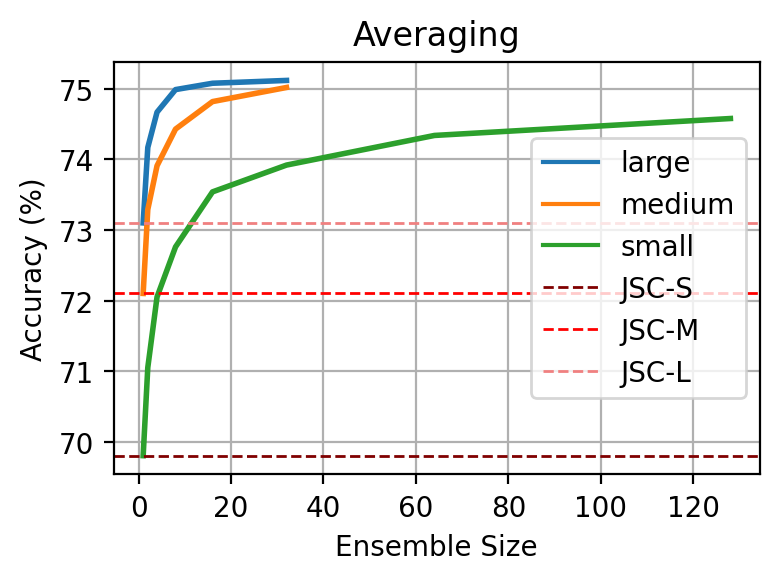

In [5]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
display(plot_df)
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # label="JSC-S Ensemble"
)
plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
ax.grid()
ax.legend()
ax.set_title("Averaging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
# ax.set_xscale("log")
fig.tight_layout()
plt.savefig("averaging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("averaging_acc_v_ensemble_size_lineplot.png")

,trial,accuracy,loss,ensemble_size,model_size
20,averaging_small_ensemble_size128,74.58,0.707,128,small
27,averaging_small_ensemble_size64,74.34,0.715,64,small
37,averaging_small_ensemble_size32,73.92,0.728,32,small
40,uniform_input_small_ensemble_size32,73.89,0.729,32,uniform_input_small
52,averaging_small_ensemble_size16,73.54,0.744,16,small
53,uniform_input_small_ensemble_size16,73.51,0.743,16,uniform_input_small
66,uniform_input_small_ensemble_size8,72.99,0.759,8,uniform_input_small
75,averaging_small_ensemble_size8,72.76,0.764,8,small
82,uniform_input_small_ensemble_size4,72.26,0.789,4,uniform_input_small
88,averaging_small_ensemble_size4,72.05,0.793,4,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


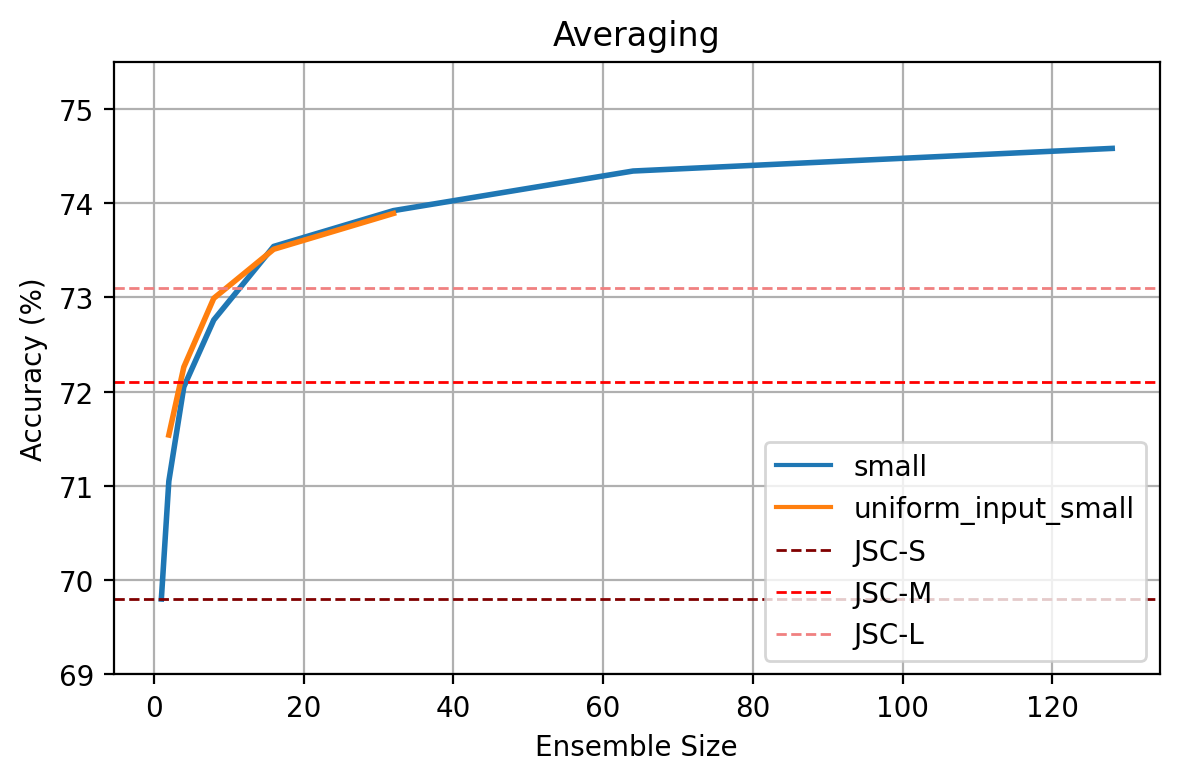

In [6]:
plot_two_ensembles(df, "small", "uniform_input_small")

,trial,accuracy,loss,ensemble_size,model_size
20,averaging_small_ensemble_size128,74.58,0.707,128,small
27,averaging_small_ensemble_size64,74.34,0.715,64,small
37,averaging_small_ensemble_size32,73.92,0.728,32,small
52,averaging_small_ensemble_size16,73.54,0.744,16,small
59,small_shared_sparse_input_layer_shared_input_b...,73.29,0.739,32,small_shared_sparse_input_layer
65,small_shared_sparse_input_layer_shared_input_b...,73.01,0.755,16,small_shared_sparse_input_layer
75,averaging_small_ensemble_size8,72.76,0.764,8,small
77,small_shared_sparse_input_layer_shared_input_b...,72.64,0.768,8,small_shared_sparse_input_layer
83,small_shared_sparse_input_layer_shared_input_b...,72.18,0.793,4,small_shared_sparse_input_layer
88,averaging_small_ensemble_size4,72.05,0.793,4,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


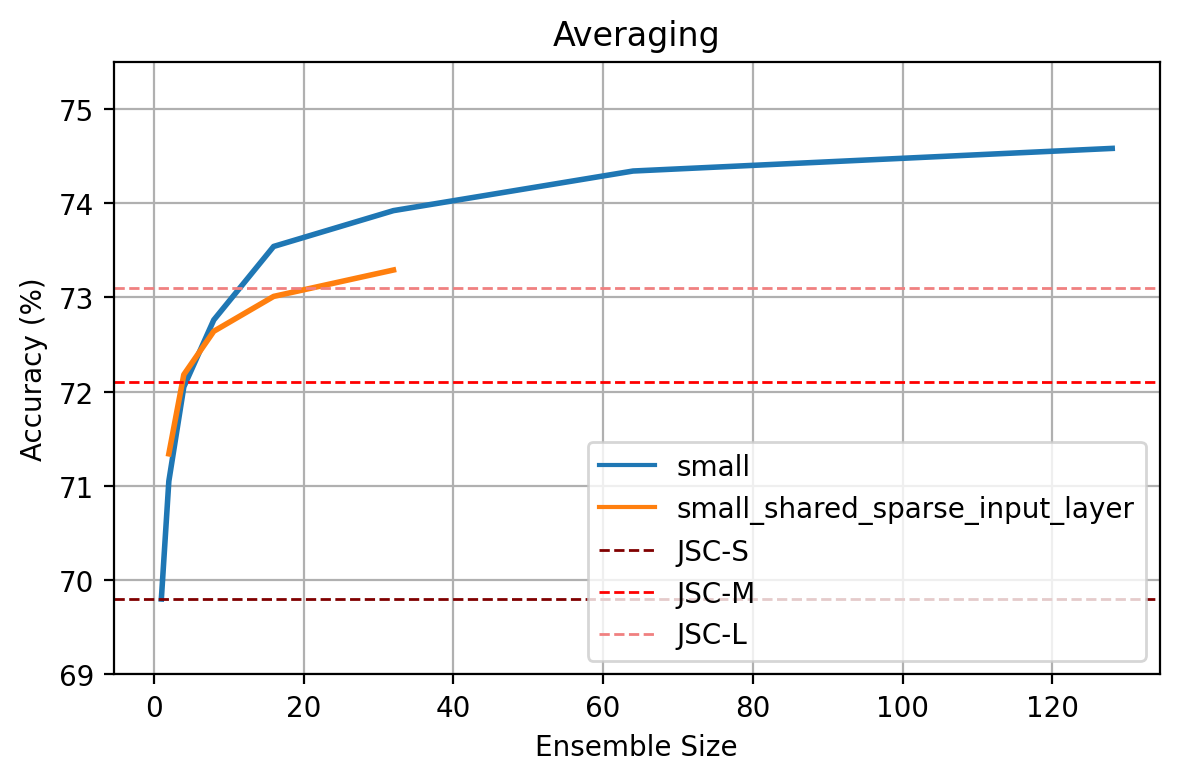

In [7]:
plot_two_ensembles(df, "small", "small_shared_sparse_input_layer")

,trial,accuracy,loss,ensemble_size,model_size
23,averaging_small_ensemble_size128,74.58,0.707,128,small
31,averaging_small_ensemble_size64,74.34,0.715,64,small
43,averaging_small_ensemble_size32,73.92,0.728,32,small
53,small_shared_input_output_layers_ensemble_size64,73.68,0.736,64,small_shared_input_output_layers
60,averaging_small_ensemble_size16,73.54,0.744,16,small
63,small_shared_input_output_layers_ensemble_size32,73.41,0.739,32,small_shared_input_output_layers
79,small_shared_input_output_layers_ensemble_size16,72.91,0.756,16,small_shared_input_output_layers
87,averaging_small_ensemble_size8,72.76,0.764,8,small
92,small_shared_input_output_layers_ensemble_size8,72.49,0.775,8,small_shared_input_output_layers
101,averaging_small_ensemble_size4,72.05,0.793,4,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


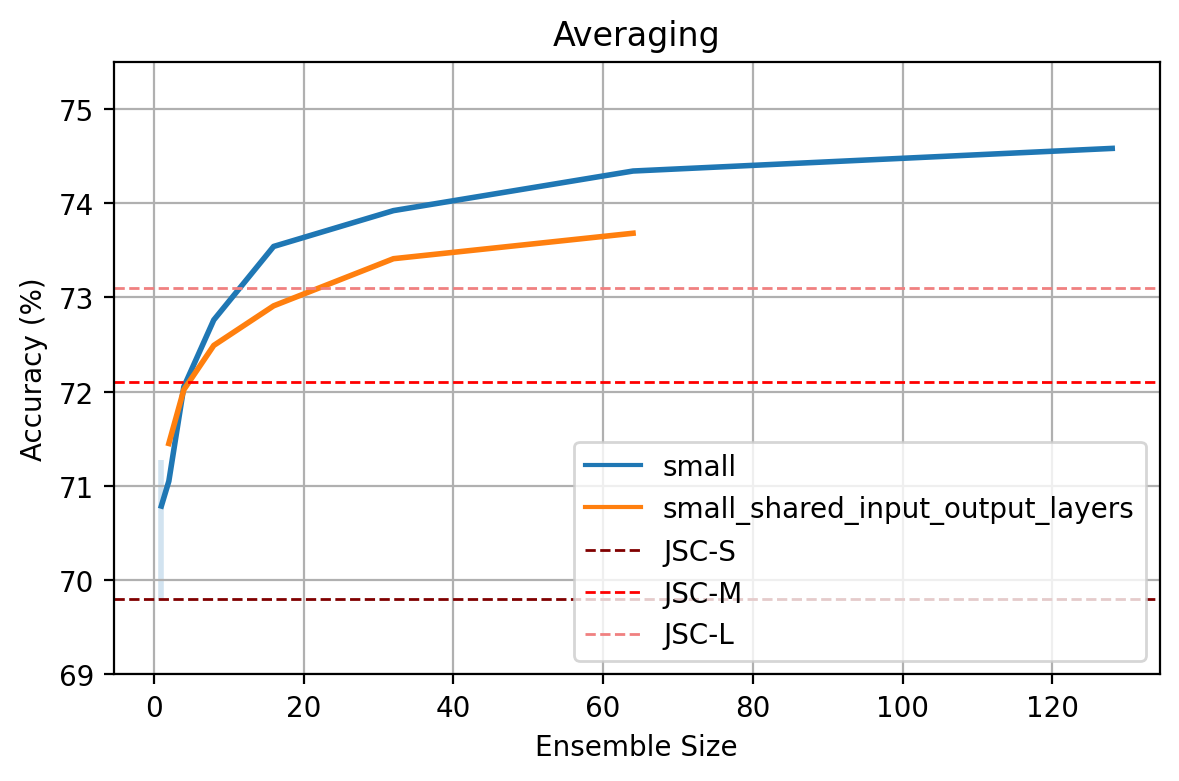

In [5]:
plot_two_ensembles(df, "small", "small_shared_input_output_layers")

,trial,accuracy,loss,ensemble_size,model_size
55,small_shared_input_output_layers_ensemble_size64,73.68,0.736,64,small_shared_input_output_layers
65,small_shared_input_output_layers_ensemble_size32,73.41,0.739,32,small_shared_input_output_layers
72,small_shared_sparse_input_layer_shared_input_b...,73.29,0.739,32,small_shared_sparse_input_layer
78,small_shared_sparse_input_layer_shared_input_b...,73.01,0.755,16,small_shared_sparse_input_layer
82,small_shared_input_output_layers_ensemble_size16,72.91,0.756,16,small_shared_input_output_layers
91,small_shared_sparse_input_layer_shared_input_b...,72.64,0.768,8,small_shared_sparse_input_layer
94,small_shared_input_output_layers_ensemble_size8,72.49,0.775,8,small_shared_input_output_layers
98,small_shared_sparse_input_layer_shared_input_b...,72.18,0.793,4,small_shared_sparse_input_layer
104,small_shared_input_output_layers_ensemble_size4,72.02,0.798,4,small_shared_input_output_layers
112,shared_sparse_input_layer_shared_input_bitwidt...,71.45,0.825,2,small_shared_input_output_layers


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


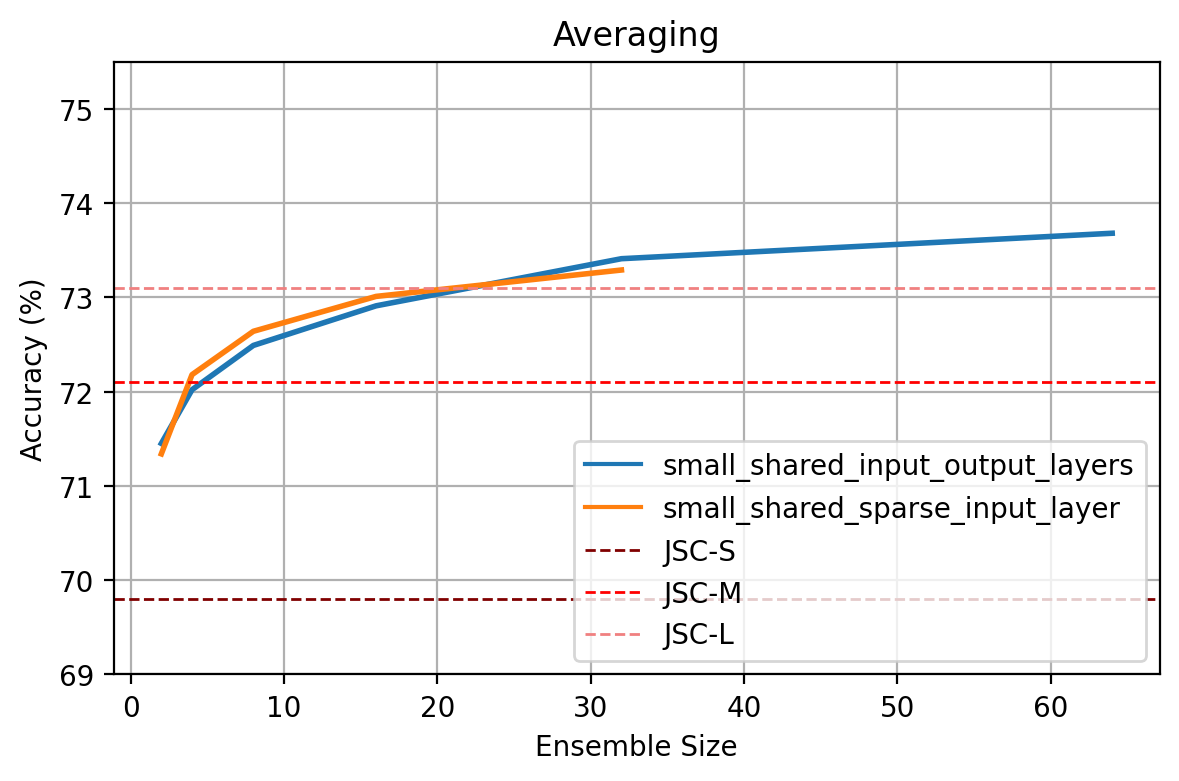

In [5]:
plot_two_ensembles(df, "small_shared_sparse_input_layer", "small_shared_input_output_layers")

,trial,accuracy,loss,ensemble_size,model_size
20,averaging_small_ensemble_size128,74.58,0.707,128,small
27,averaging_small_ensemble_size64,74.34,0.715,64,small
37,averaging_small_ensemble_size32,73.92,0.728,32,small
52,averaging_small_ensemble_size16,73.54,0.744,16,small
75,averaging_small_ensemble_size8,72.76,0.764,8,small
88,averaging_small_ensemble_size4,72.05,0.793,4,small
96,shared_sparse_input_layer_shared_input_bitwidt...,71.45,0.825,2,small_same_input_scale
98,small_same_input_scale_ensemble_size32,71.33,0.801,32,small_same_input_scale
104,small_same_input_scale_ensemble_size16,71.15,0.809,16,small_same_input_scale
106,averaging_small_ensemble_size2,71.05,0.838,2,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


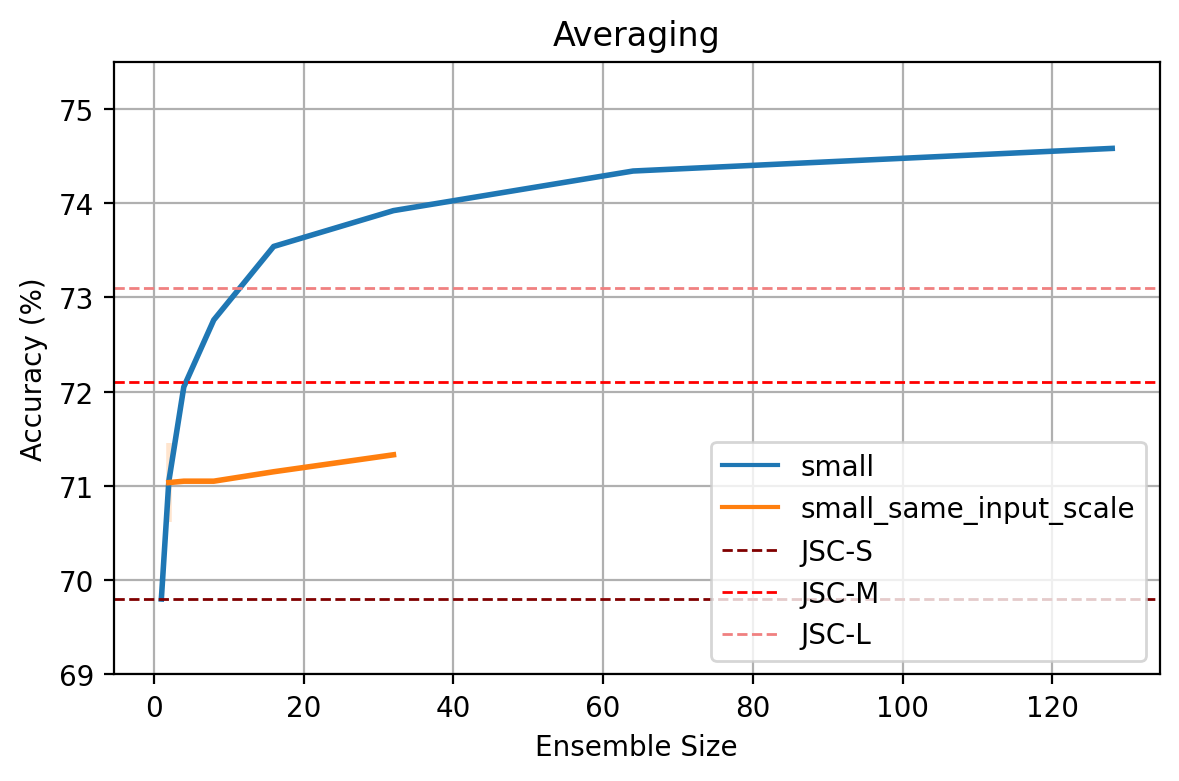

In [8]:
plot_two_ensembles(df, "small", "small_same_input_scale")

,trial,accuracy,loss,ensemble_size,model_size
20,averaging_small_ensemble_size128,74.58,0.707,128,small
26,averaging_small_ensemble_size64,74.34,0.715,64,small
36,averaging_small_ensemble_size32,73.92,0.728,32,small
47,averaging_small_ensemble_size16,73.54,0.744,16,small
70,averaging_small_ensemble_size8,72.76,0.764,8,small
81,averaging_small_ensemble_size4,72.05,0.793,4,small
96,averaging_small_ensemble_size2,71.05,0.838,2,small
97,small_input_post_trans_sbs_ensemble_size8,71.01,0.818,8,small_input_post_trans_sbs
98,small_input_post_trans_sbs_ensemble_size4,70.86,0.835,4,small_input_post_trans_sbs
101,small_input_post_trans_sbs_ensemble_size2,70.65,0.842,2,small_input_post_trans_sbs


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


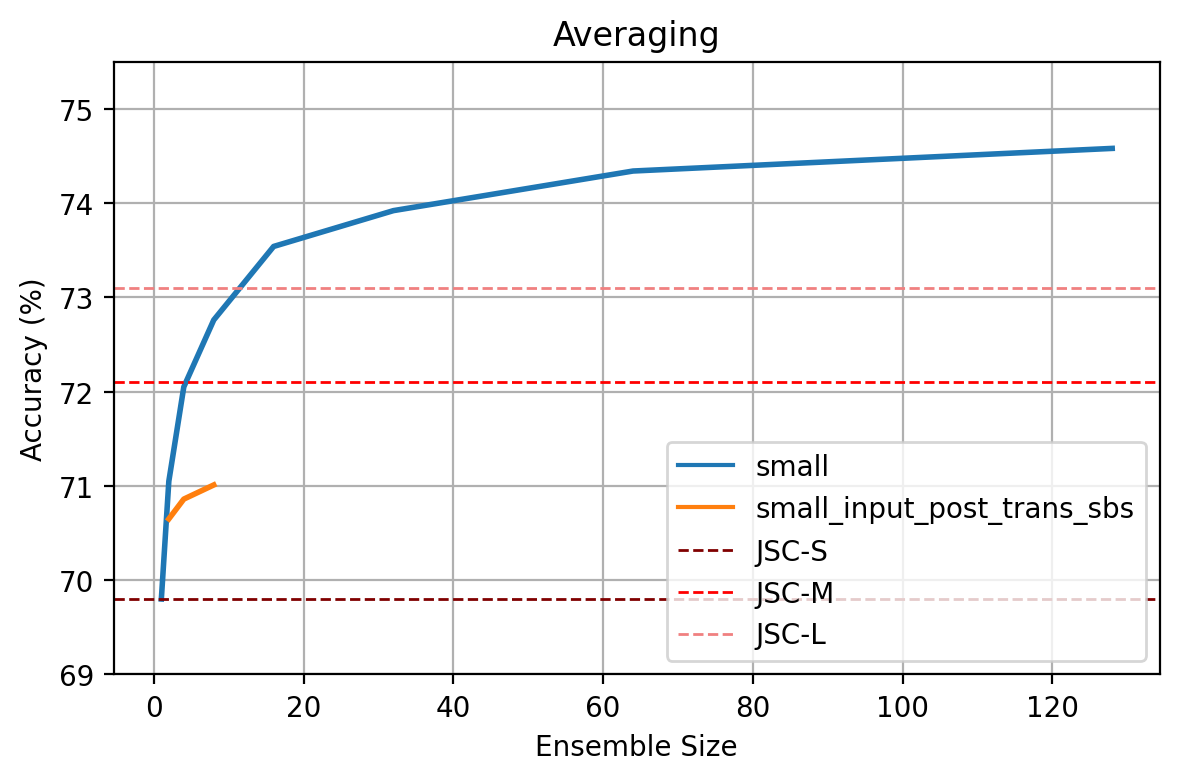

In [37]:
plot_two_ensembles(df, "small", "small_input_post_trans_sbs")

,trial,accuracy,loss,ensemble_size,model_size
89,small_same_input_scale_ensemble_size32,71.33,0.801,32,small_same_input_scale
93,small_same_input_scale_ensemble_size16,71.15,0.809,16,small_same_input_scale
94,small_same_input_scale_ensemble_size8,71.05,0.817,8,small_same_input_scale
95,small_same_input_scale_ensemble_size4,71.05,0.830,4,small_same_input_scale
97,small_input_post_trans_sbs_ensemble_size8,71.01,0.818,8,small_input_post_trans_sbs
98,small_input_post_trans_sbs_ensemble_size4,70.86,0.835,4,small_input_post_trans_sbs
101,small_input_post_trans_sbs_ensemble_size2,70.65,0.842,2,small_input_post_trans_sbs
102,small_same_input_scale_ensemble_size2,70.62,0.852,2,small_same_input_scale


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


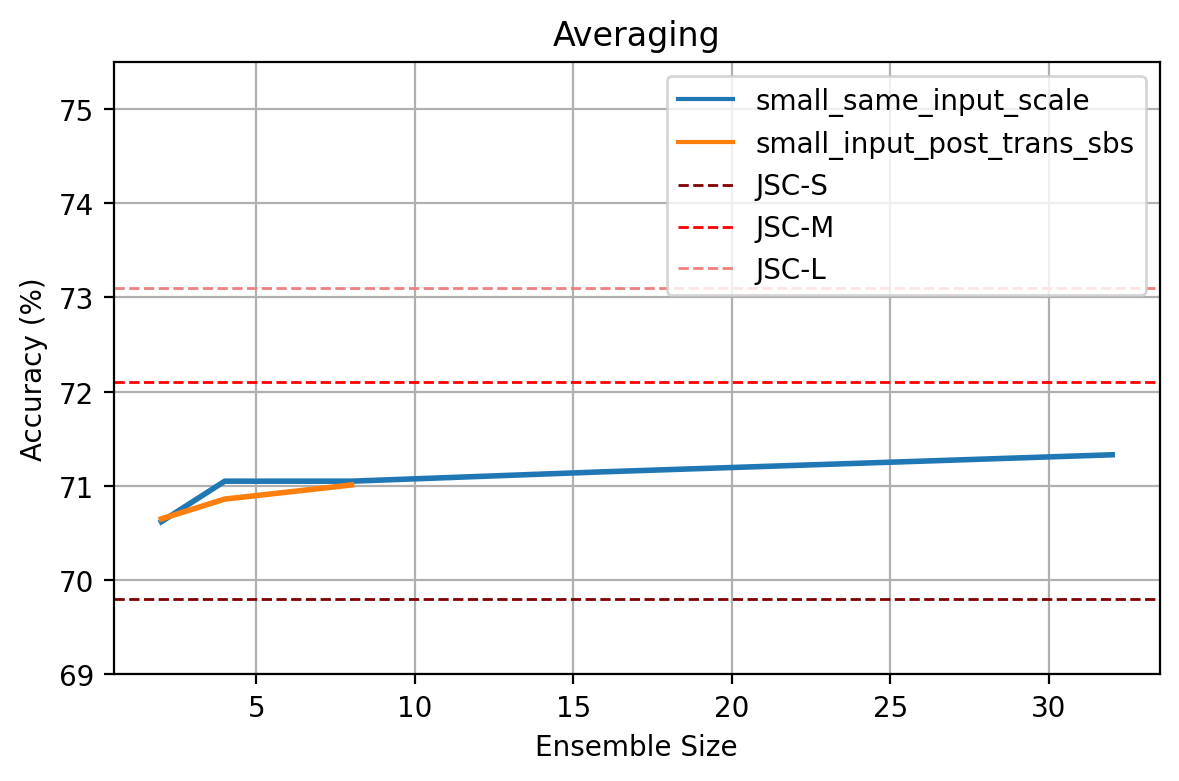

In [38]:
plot_two_ensembles(df, "small_same_input_scale", "small_input_post_trans_sbs")

,trial,accuracy,loss,ensemble_size,model_size
14,averaging_small_ensemble_size128,74.58,0.707,128,small
20,averaging_small_ensemble_size64,74.34,0.715,64,small
28,averaging_small_ensemble_size32,73.92,0.728,32,small
34,averaging_small_ensemble_size16,73.54,0.744,16,small
35,small_same_output_scale_post_trans_ensemble_si...,73.54,0.781,128,small_same_output_scale_post_trans
42,small_same_output_scale_post_trans_ensemble_si...,73.05,0.803,32,small_same_output_scale_post_trans
44,small_same_output_scale_post_trans_ensemble_si...,72.91,0.801,32,small_same_output_scale_post_trans
46,averaging_small_ensemble_size8,72.76,0.764,8,small
48,small_same_output_scale_post_trans_ensemble_si...,72.44,0.810,64,small_same_output_scale_post_trans
49,small_same_output_scale_post_trans_ensemble_si...,72.15,0.832,16,small_same_output_scale_post_trans


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


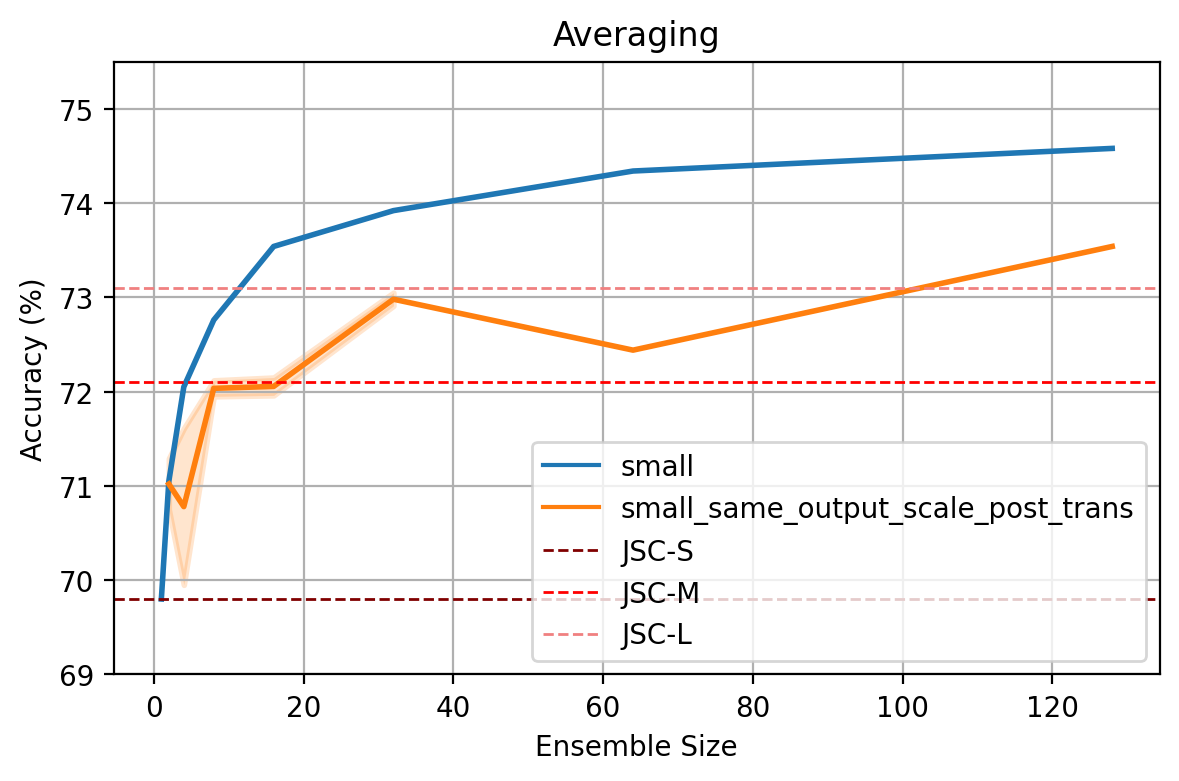

In [5]:
plot_two_ensembles(df, "small", "small_same_output_scale_post_trans")

,trial,accuracy,loss,ensemble_size,model_size
9,averaging_medium_ensemble_size32,75.02,0.693,32,medium
17,averaging_medium_ensemble_size16,74.82,0.698,16,medium
21,medium_shared_input_output_layers_ensemble_size32,74.75,0.700,32,medium_shared_input_output_layers
31,averaging_medium_ensemble_size8,74.43,0.709,8,medium
32,medium_shared_input_output_layers_ensemble_size16,74.41,0.708,16,medium_shared_input_output_layers
40,medium_shared_input_output_layers_ensemble_size8,74.04,0.718,8,medium_shared_input_output_layers
41,medium_shared_input_output_layers_ensemble_size4,74.03,0.726,4,medium_shared_input_output_layers
46,averaging_medium_ensemble_size4,73.91,0.728,4,medium
69,medium_shared_input_output_layers_ensemble_size2,73.33,0.746,2,medium_shared_input_output_layers
71,averaging_medium_ensemble_size2,73.29,0.748,2,medium


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


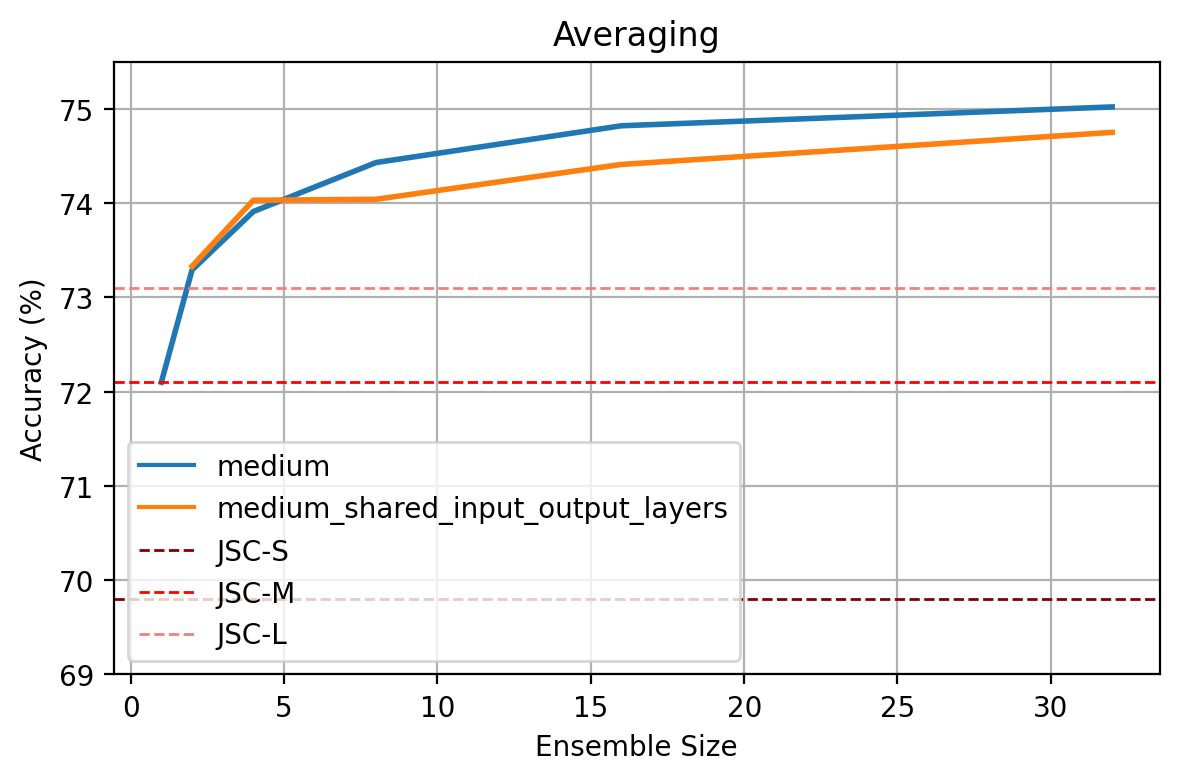

In [4]:
plot_two_ensembles(df, "medium", "medium_shared_input_output_layers")

,trial,accuracy,loss,ensemble_size,model_size
9,averaging_medium_ensemble_size32,75.02,0.693,32,medium
17,averaging_medium_ensemble_size16,74.82,0.698,16,medium
31,averaging_medium_ensemble_size8,74.43,0.709,8,medium
46,averaging_medium_ensemble_size4,73.91,0.728,4,medium
71,averaging_medium_ensemble_size2,73.29,0.748,2,medium
76,medium_shared_sparse_input_layer_shared_input_...,73.05,0.751,2,medium_shared_sparse_input_layer
101,best_single_model_medium,72.10,0.000,1,medium


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


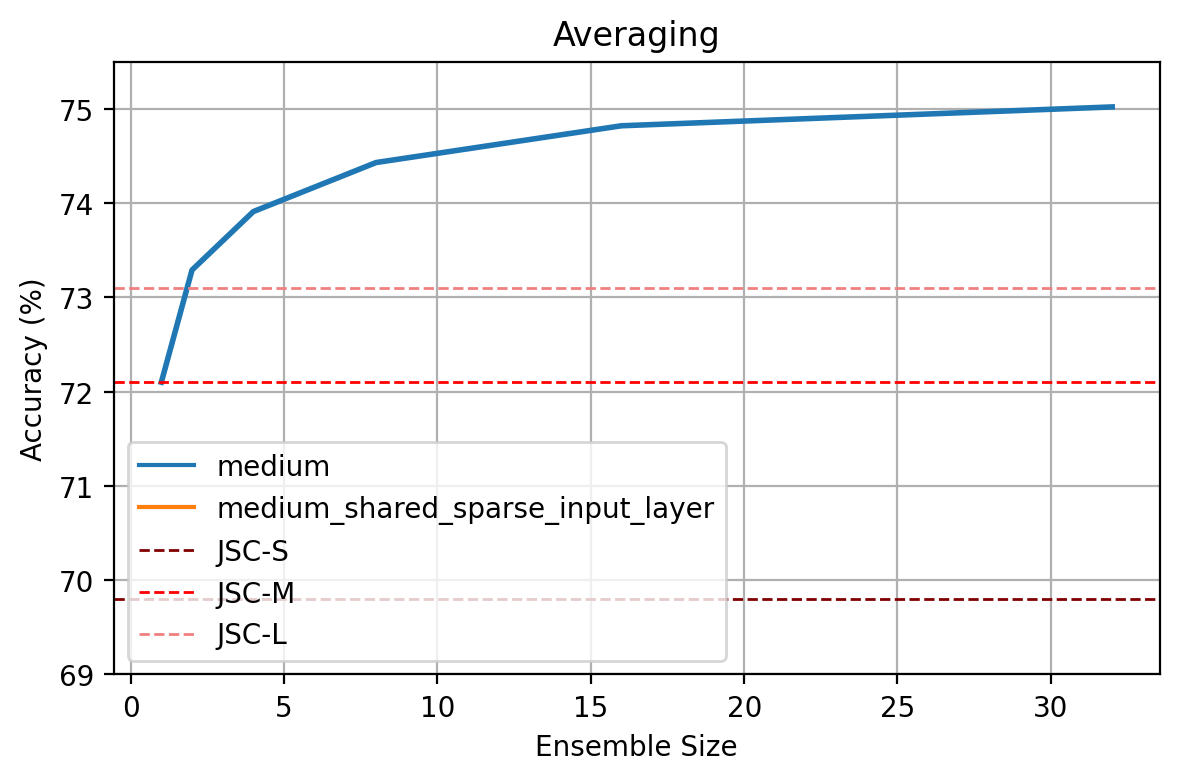

In [4]:
plot_two_ensembles(df, "medium", "medium_shared_sparse_input_layer")

,trial,accuracy,loss,ensemble_size,model_size
6,uniform_input_medium_ensemble_size32,75.03,0.692,32,uniform_input_medium
8,averaging_medium_ensemble_size32,75.02,0.693,32,medium
13,uniform_input_medium_ensemble_size16,74.89,0.697,16,uniform_input_medium
15,averaging_medium_ensemble_size16,74.82,0.698,16,medium
21,uniform_input_medium_ensemble_size8,74.57,0.708,8,uniform_input_medium
25,averaging_medium_ensemble_size8,74.43,0.709,8,medium
33,uniform_input_medium_ensemble_size4,74.02,0.723,4,uniform_input_medium
37,averaging_medium_ensemble_size4,73.91,0.728,4,medium
52,uniform_input_medium_ensemble_size2,73.34,0.746,2,uniform_input_medium
53,averaging_medium_ensemble_size2,73.29,0.748,2,medium


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


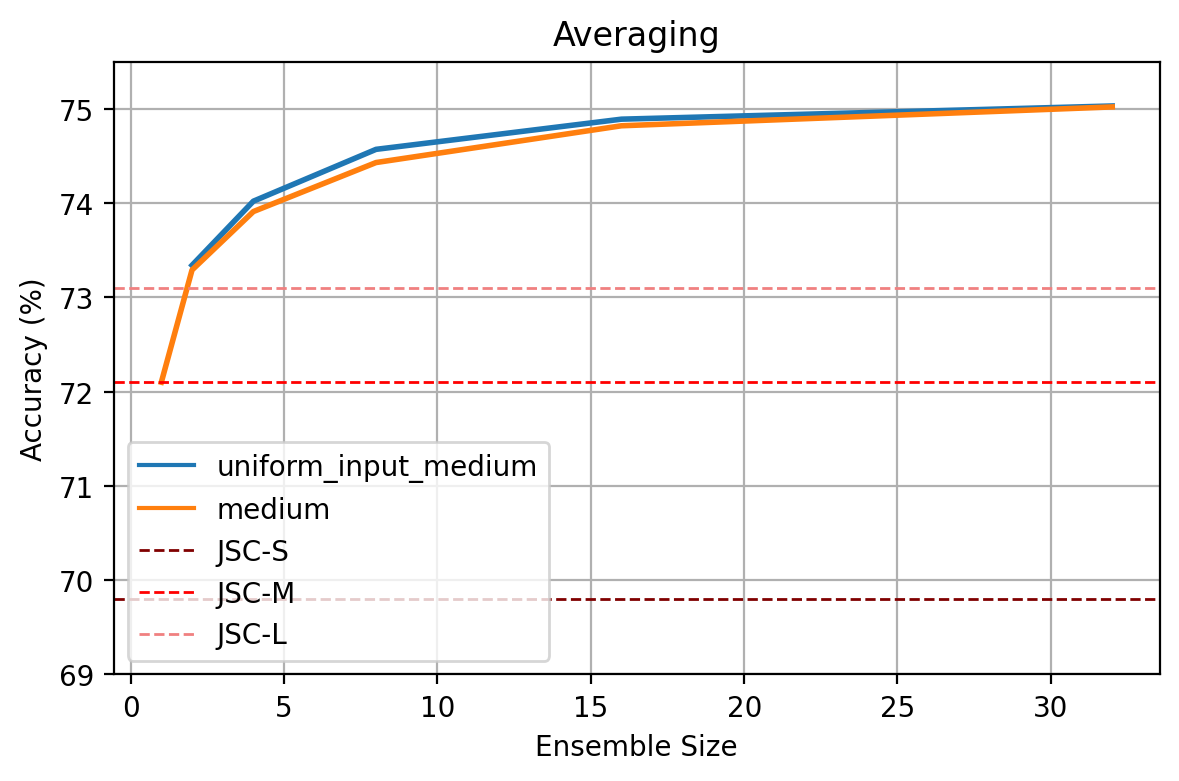

In [21]:
plot_two_ensembles(df, "medium",  "uniform_input_medium")

,trial,accuracy,loss,ensemble_size,model_size
6,averaging_medium_ensemble_size32,75.02,0.693,32,medium
11,averaging_medium_ensemble_size16,74.82,0.698,16,medium
19,averaging_medium_ensemble_size8,74.43,0.709,8,medium
29,averaging_medium_ensemble_size4,73.91,0.728,4,medium
40,averaging_medium_ensemble_size2,73.29,0.748,2,medium
49,medium_same_input_scale_ensemble_size8,72.87,0.752,8,medium_same_input_scale
50,medium_same_input_scale_ensemble_size16,72.81,0.752,16,medium_same_input_scale
51,medium_same_input_scale_ensemble_size4,72.78,0.757,4,medium_same_input_scale
54,medium_same_input_scale_ensemble_size2,72.50,0.766,2,medium_same_input_scale
58,best_single_model_medium,72.10,0.000,1,medium


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


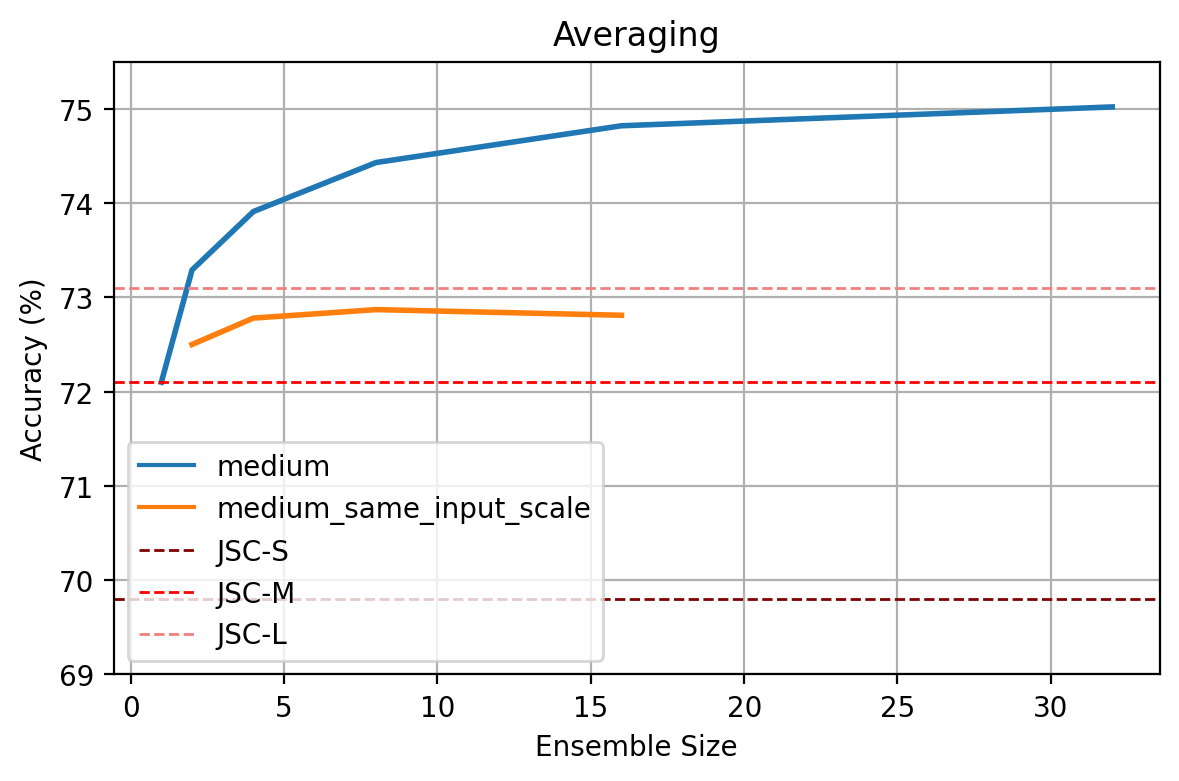

In [6]:
plot_two_ensembles(df, "medium", "medium_same_input_scale")

,trial,accuracy,loss,ensemble_size,model_size
8,averaging_medium_ensemble_size32,75.02,0.693,32,medium
15,averaging_medium_ensemble_size16,74.82,0.698,16,medium
25,averaging_medium_ensemble_size8,74.43,0.709,8,medium
37,averaging_medium_ensemble_size4,73.91,0.728,4,medium
55,averaging_medium_ensemble_size2,73.29,0.748,2,medium
66,medium_input_post_trans_sbs_ensemble_size8,72.83,0.752,8,medium_input_post_trans_sbs
71,medium_input_post_trans_sbs_ensemble_size4,72.67,0.758,4,medium_input_post_trans_sbs
74,medium_input_post_trans_sbs_ensemble_size2,72.47,0.766,2,medium_input_post_trans_sbs
79,best_single_model_medium,72.10,0.000,1,medium


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


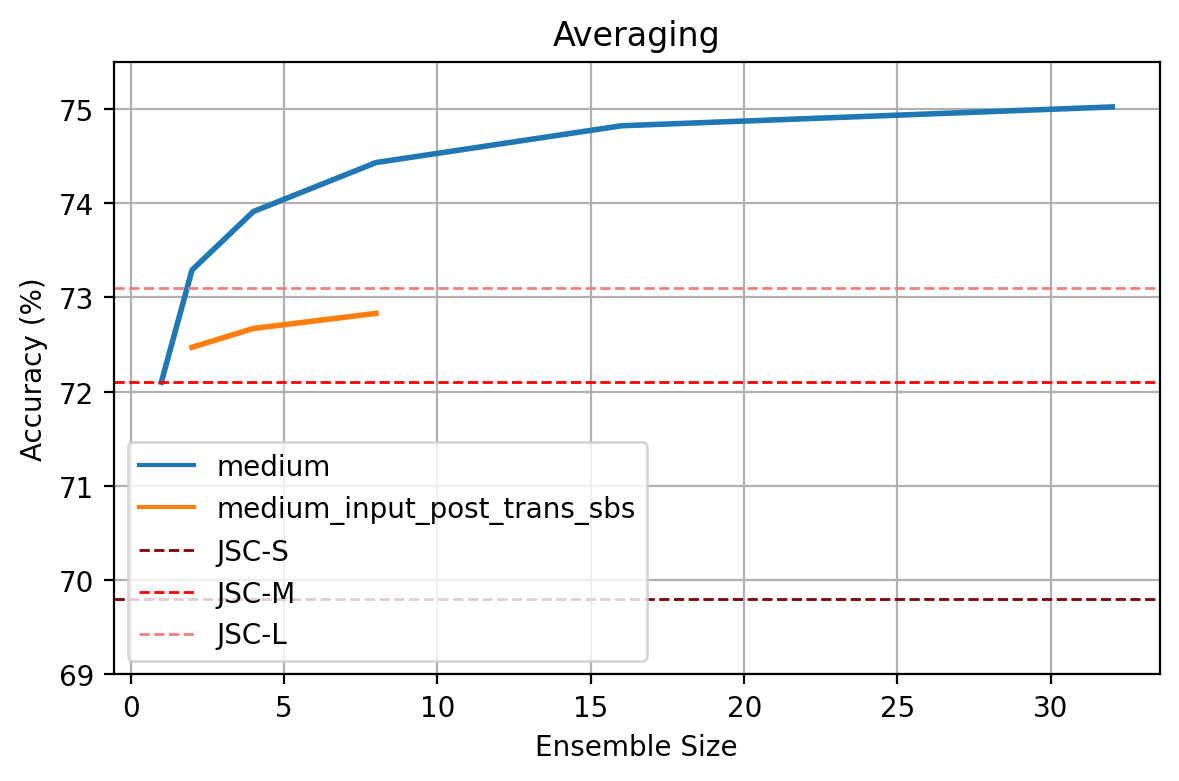

In [39]:
plot_two_ensembles(df, "medium", "medium_input_post_trans_sbs")

,trial,accuracy,loss,ensemble_size,model_size
65,medium_same_input_scale_ensemble_size8,72.87,0.752,8,medium_same_input_scale
66,medium_input_post_trans_sbs_ensemble_size8,72.83,0.752,8,medium_input_post_trans_sbs
67,medium_same_input_scale_ensemble_size16,72.81,0.752,16,medium_same_input_scale
68,medium_same_input_scale_ensemble_size4,72.78,0.757,4,medium_same_input_scale
69,medium_same_input_scale_ensemble_size32,72.77,0.752,32,medium_same_input_scale
71,medium_input_post_trans_sbs_ensemble_size4,72.67,0.758,4,medium_input_post_trans_sbs
72,medium_same_input_scale_ensemble_size2,72.50,0.766,2,medium_same_input_scale
74,medium_input_post_trans_sbs_ensemble_size2,72.47,0.766,2,medium_input_post_trans_sbs


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


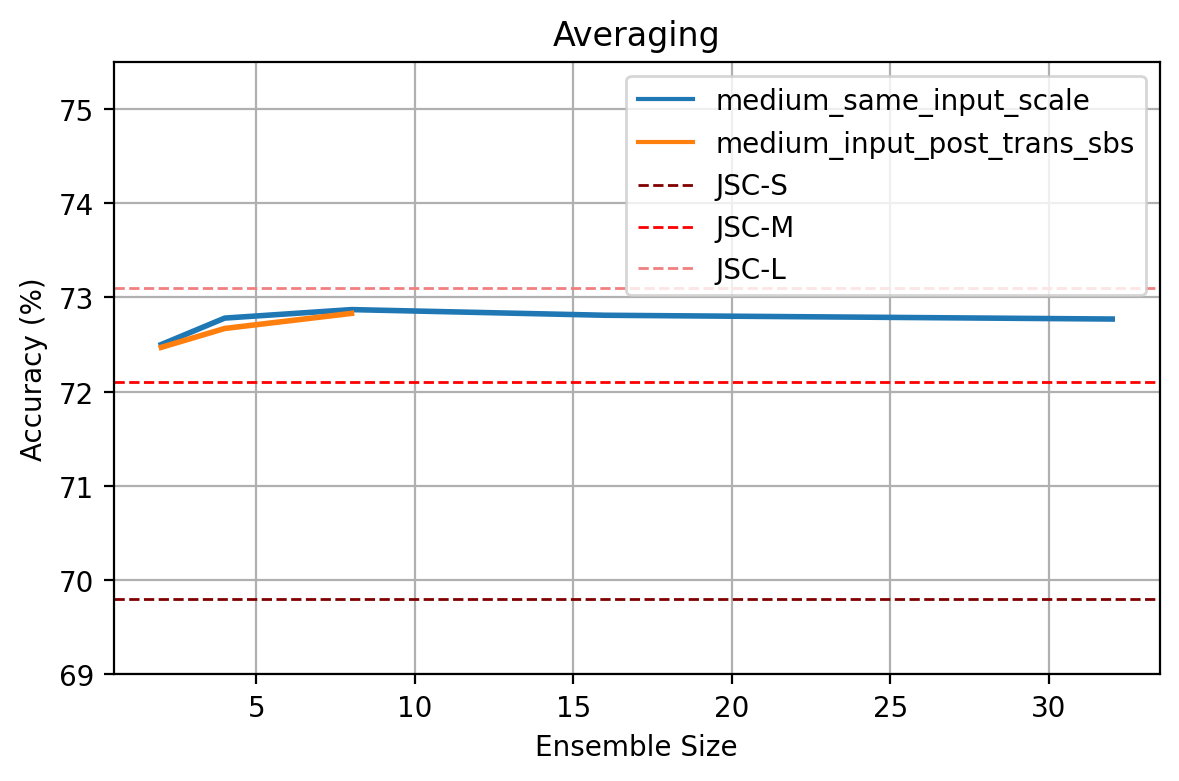

In [40]:
plot_two_ensembles(df, "medium_same_input_scale", "medium_input_post_trans_sbs")

,trial,accuracy,loss,ensemble_size,model_size
6,averaging_medium_ensemble_size32,75.02,0.693,32,medium
11,averaging_medium_ensemble_size16,74.82,0.698,16,medium
19,averaging_medium_ensemble_size8,74.43,0.709,8,medium
21,medium_same_output_scale_post_trans_ensemble_s...,74.33,0.731,16,medium_same_output_scale_post_trans
22,medium_same_output_scale_post_trans_ensemble_s...,74.30,0.737,8,medium_same_output_scale_post_trans
30,averaging_medium_ensemble_size4,73.91,0.728,4,medium
31,medium_same_output_scale_post_trans_ensemble_s...,73.82,0.736,4,medium_same_output_scale_post_trans
38,averaging_medium_ensemble_size2,73.29,0.748,2,medium
39,medium_same_output_scale_post_trans_ensemble_s...,73.23,0.751,2,medium_same_output_scale_post_trans
51,best_single_model_medium,72.10,0.000,1,medium


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


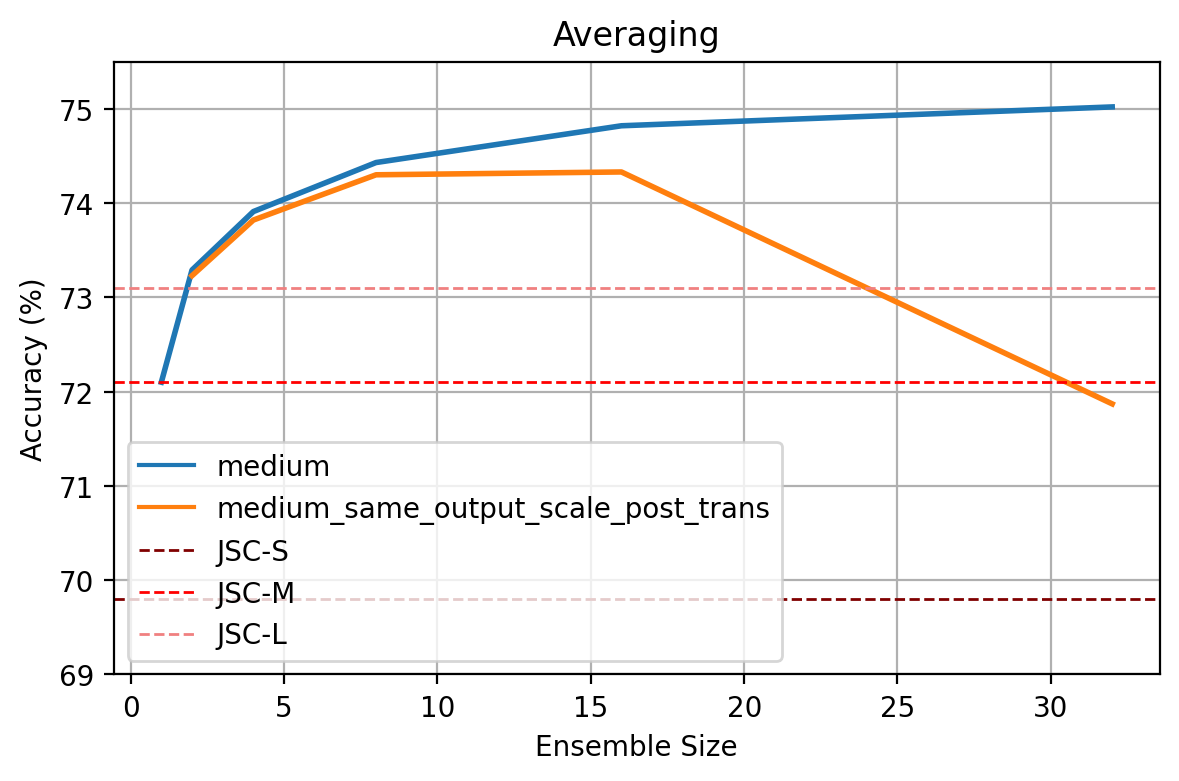

In [6]:
plot_two_ensembles(df, "medium", "medium_same_output_scale_post_trans")

,trial,accuracy,loss,ensemble_size,model_size
4,averaging_large_ensemble_size32,75.12,0.688,32,large
6,averaging_large_ensemble_size16,75.08,0.689,16,large
12,averaging_large_ensemble_size8,74.99,0.693,8,large
15,large_shared_input_output_layers_ensemble_size8,74.85,0.699,8,large_shared_input_output_layers
18,large_shared_input_output_layers_ensemble_size16,74.78,0.699,16,large_shared_input_output_layers
19,large_shared_input_output_layers_ensemble_size32,74.76,0.701,32,large_shared_input_output_layers
22,averaging_large_ensemble_size4,74.67,0.703,4,large
30,large_shared_input_output_layers_ensemble_size4,74.43,0.710,4,large_shared_input_output_layers
36,averaging_large_ensemble_size2,74.17,0.718,2,large
53,large_shared_input_output_layers_ensemble_size2,73.77,0.726,2,large_shared_input_output_layers


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


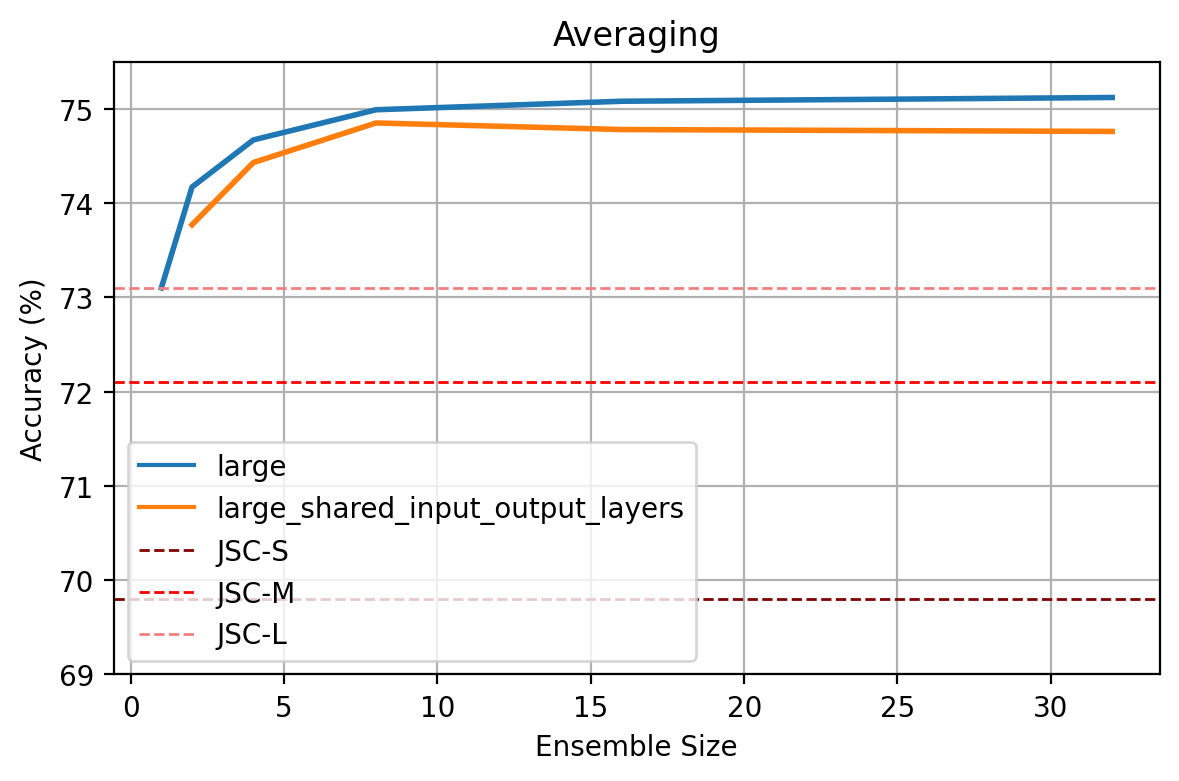

In [5]:
plot_two_ensembles(df, "large", "large_shared_input_output_layers")

,trial,accuracy,loss,ensemble_size,model_size
3,averaging_large_ensemble_size32,75.12,0.688,32,large
4,uniform_input_large_ensemble_size16,75.10,0.689,16,uniform_input_large
5,averaging_large_ensemble_size16,75.08,0.689,16,large
10,uniform_input_large_ensemble_size8,75.00,0.692,8,uniform_input_large
11,averaging_large_ensemble_size8,74.99,0.693,8,large
17,averaging_large_ensemble_size4,74.67,0.703,4,large
18,uniform_input_large_ensemble_size4,74.64,0.702,4,uniform_input_large
30,averaging_large_ensemble_size2,74.17,0.718,2,large
31,uniform_input_large_ensemble_size2,74.12,0.718,2,uniform_input_large
57,best_single_model_large,73.10,0.000,1,large


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


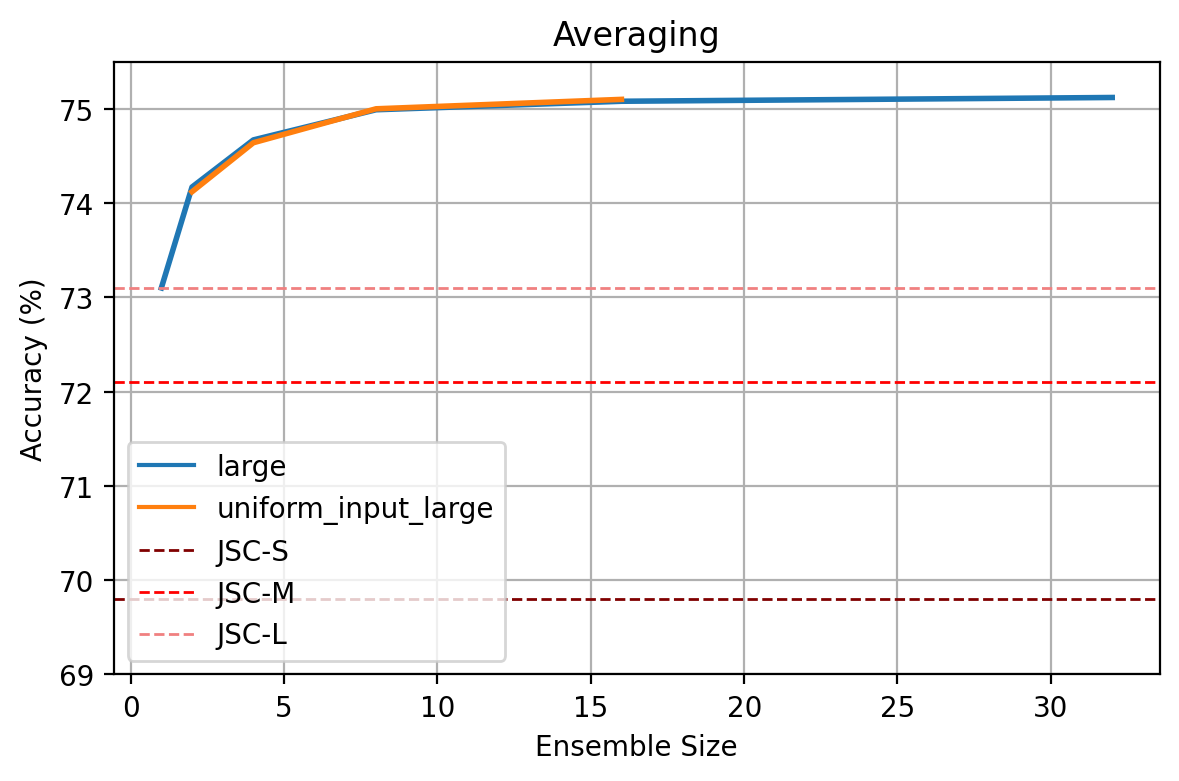

In [19]:
plot_two_ensembles(df, "large", "uniform_input_large")

,trial,accuracy,loss,ensemble_size,model_size
3,averaging_large_ensemble_size32,75.12,0.688,32,large
4,averaging_large_ensemble_size16,75.08,0.689,16,large
8,averaging_large_ensemble_size8,74.99,0.693,8,large
13,averaging_large_ensemble_size4,74.67,0.703,4,large
23,averaging_large_ensemble_size2,74.17,0.718,2,large
34,large_same_input_scale_ensemble_size8,73.68,0.728,8,large_same_input_scale
35,large_same_input_scale_ensemble_size4,73.54,0.732,4,large_same_input_scale
41,large_same_input_scale_ensemble_size2,73.29,0.739,2,large_same_input_scale
44,best_single_model_large,73.10,0.000,1,large


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


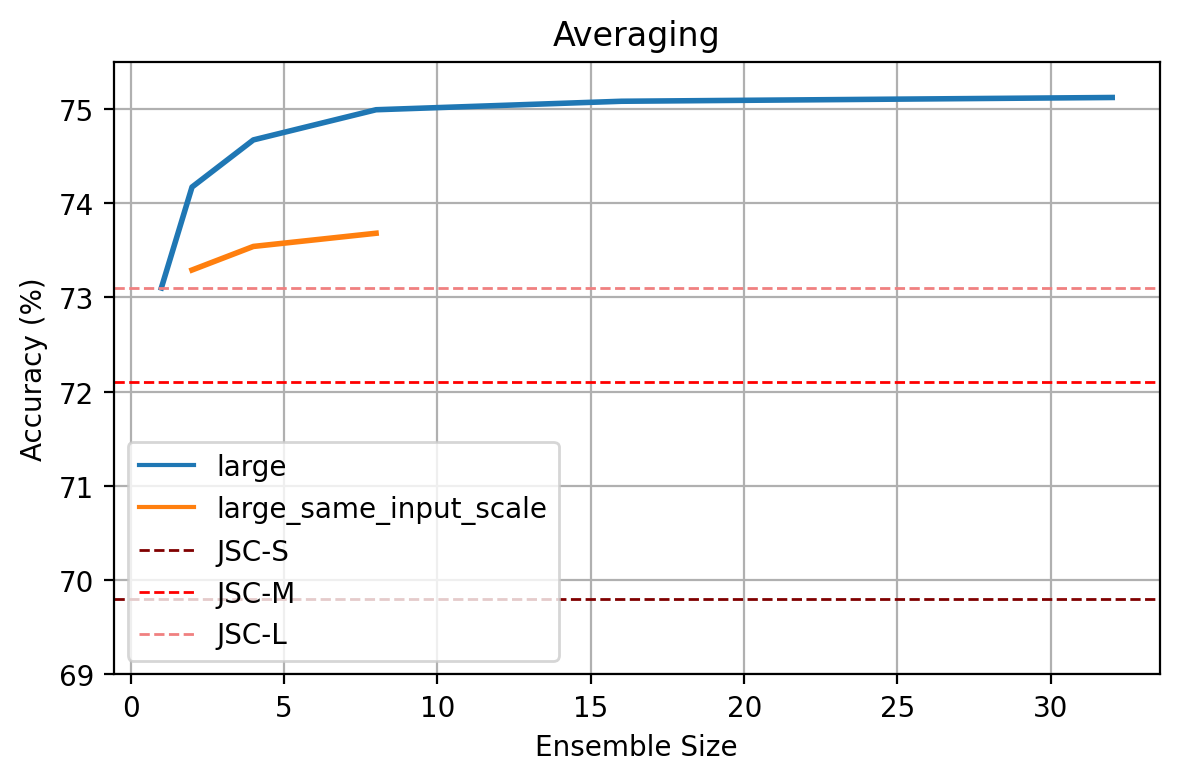

In [7]:
plot_two_ensembles(df, "large", "large_same_input_scale")

,trial,accuracy,loss,ensemble_size,model_size
3,averaging_large_ensemble_size32,75.12,0.688,32,large
5,averaging_large_ensemble_size16,75.08,0.689,16,large
11,averaging_large_ensemble_size8,74.99,0.693,8,large
17,averaging_large_ensemble_size4,74.67,0.703,4,large
30,averaging_large_ensemble_size2,74.17,0.718,2,large
44,large_input_post_trans_sbs_ensemble_size8,73.66,0.730,8,large_input_post_trans_sbs
46,large_input_post_trans_sbs_ensemble_size4,73.55,0.732,4,large_input_post_trans_sbs
53,large_input_post_trans_sbs_ensemble_size2,73.41,0.736,2,large_input_post_trans_sbs
60,best_single_model_large,73.10,0.000,1,large


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


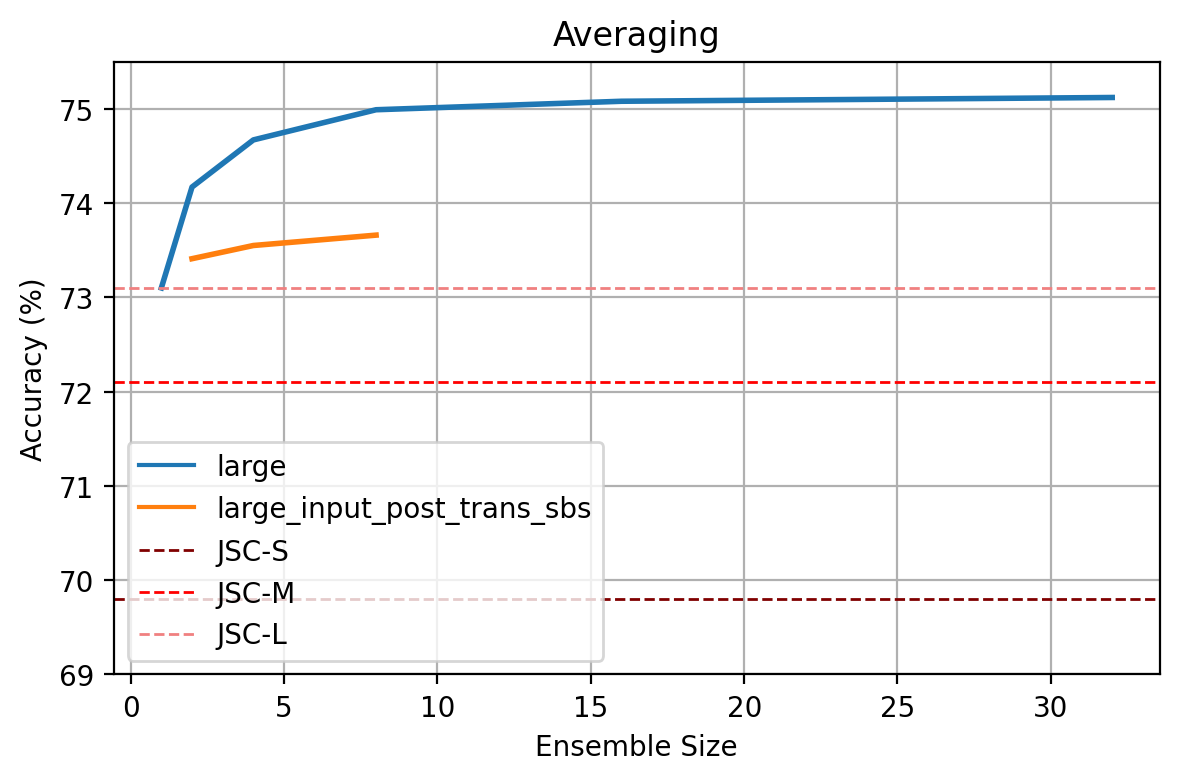

In [5]:
plot_two_ensembles(df, "large", "large_input_post_trans_sbs")

,trial,accuracy,loss,ensemble_size,model_size
43,large_same_input_scale_ensemble_size8,73.68,0.728,8,large_same_input_scale
44,large_input_post_trans_sbs_ensemble_size8,73.66,0.730,8,large_input_post_trans_sbs
45,large_same_input_scale_ensemble_size16,73.62,0.729,16,large_same_input_scale
46,large_input_post_trans_sbs_ensemble_size4,73.55,0.732,4,large_input_post_trans_sbs
48,large_same_input_scale_ensemble_size32,73.54,0.732,32,large_same_input_scale
49,large_same_input_scale_ensemble_size4,73.54,0.732,4,large_same_input_scale
53,large_input_post_trans_sbs_ensemble_size2,73.41,0.736,2,large_input_post_trans_sbs
57,large_same_input_scale_ensemble_size2,73.29,0.739,2,large_same_input_scale


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


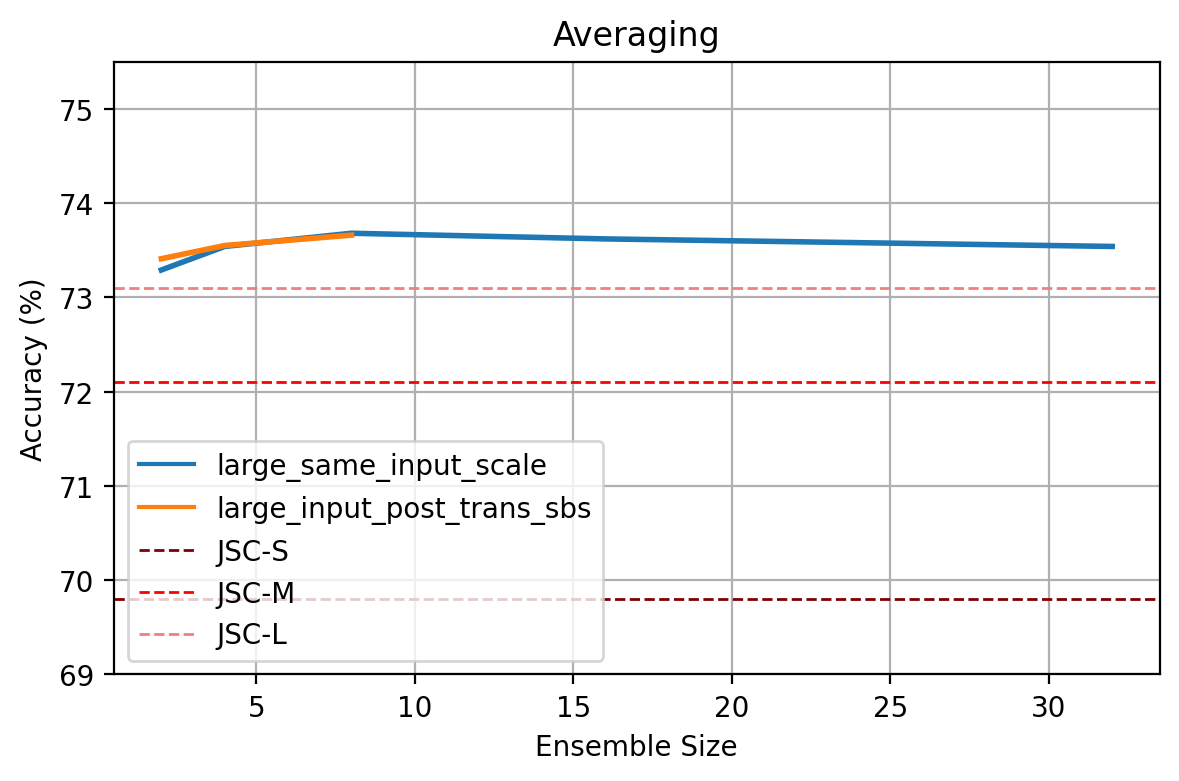

In [6]:
plot_two_ensembles(df, "large_same_input_scale", "large_input_post_trans_sbs")

,trial,accuracy,loss,ensemble_size,model_size
3,averaging_large_ensemble_size32,75.12,0.688,32,large
4,averaging_large_ensemble_size16,75.08,0.689,16,large
7,large_same_output_scale_post_trans_ensemble_si...,75.01,0.694,16,large_same_output_scale_post_trans
8,averaging_large_ensemble_size8,74.99,0.693,8,large
12,large_same_output_scale_post_trans_ensemble_size8,74.76,0.707,8,large_same_output_scale_post_trans
13,averaging_large_ensemble_size4,74.67,0.703,4,large
15,large_same_output_scale_post_trans_ensemble_size4,74.58,0.710,4,large_same_output_scale_post_trans
24,averaging_large_ensemble_size2,74.17,0.718,2,large
26,large_same_output_scale_post_trans_ensemble_size2,73.99,0.723,2,large_same_output_scale_post_trans
37,large_same_output_scale_post_trans_ensemble_si...,73.39,0.734,32,large_same_output_scale_post_trans


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


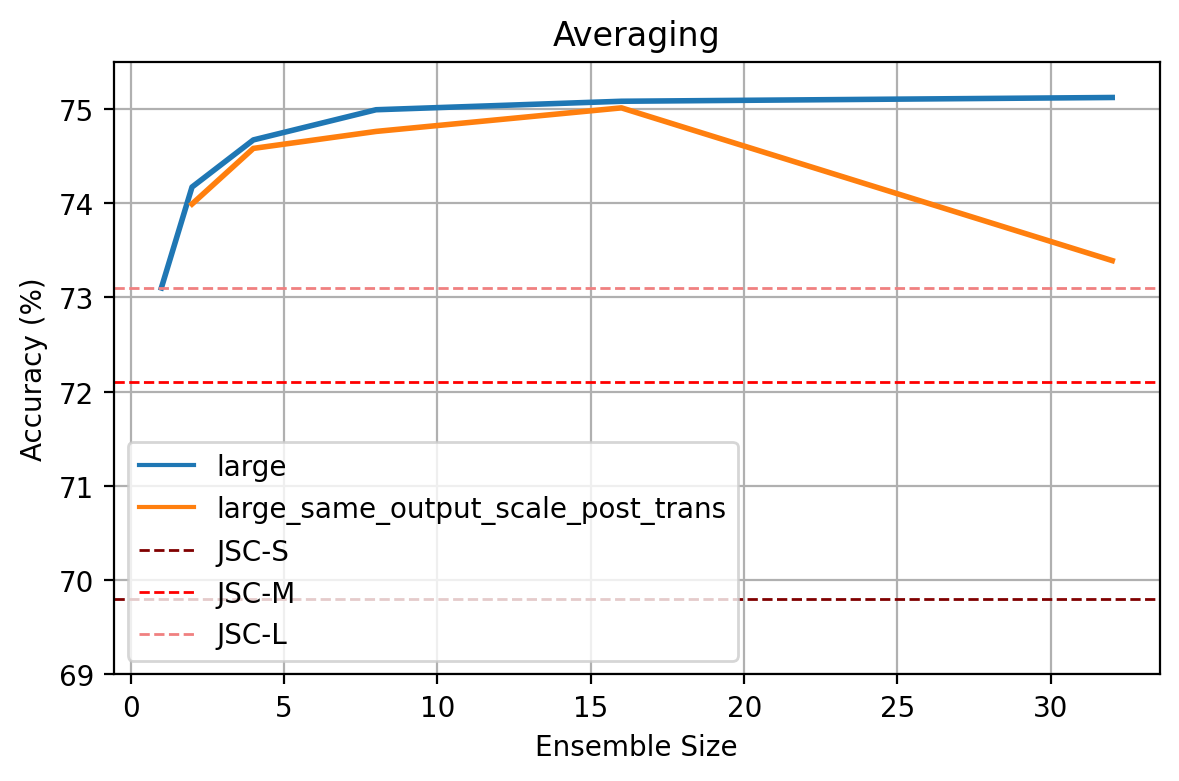

In [7]:
plot_two_ensembles(df, "large", "large_same_output_scale_post_trans")

## Bagging

In [5]:
experiment_dir = "../bagging"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
bagging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,bagging_large_independent_ensemble_size32,73.796,0.724,31,large_independent
1,bagging_large_independent_ensemble_size32,73.793,0.724,24,large_independent
2,bagging_large_independent_ensemble_size32,73.792,0.724,26,large_independent
3,bagging_large_independent_ensemble_size32,73.791,0.724,25,large_independent
4,bagging_large_independent_ensemble_size32,73.790,0.724,28,large_independent
...,...,...,...,...,...
184,bagging_small_independent_ensemble_size32,71.011,0.843,3,small_independent
185,bagging_small_independent_ensemble_size32,70.731,0.860,2,small_independent
186,bagging_small_independent_ensemble_size32,70.261,0.894,1,small_independent
187,bagging_small_ensemble_size32,70.261,0.894,1,small


,trial,accuracy,loss,ensemble_size,model_size
0,bagging_large_independent_ensemble_size32,73.796,0.724,31,large_independent
1,bagging_large_independent_ensemble_size32,73.793,0.724,24,large_independent
2,bagging_large_independent_ensemble_size32,73.792,0.724,26,large_independent
3,bagging_large_independent_ensemble_size32,73.791,0.724,25,large_independent
4,bagging_large_independent_ensemble_size32,73.790,0.724,28,large_independent
...,...,...,...,...,...
184,bagging_small_independent_ensemble_size32,71.011,0.843,3,small_independent
185,bagging_small_independent_ensemble_size32,70.731,0.860,2,small_independent
186,bagging_small_independent_ensemble_size32,70.261,0.894,1,small_independent
187,bagging_small_ensemble_size32,70.261,0.894,1,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


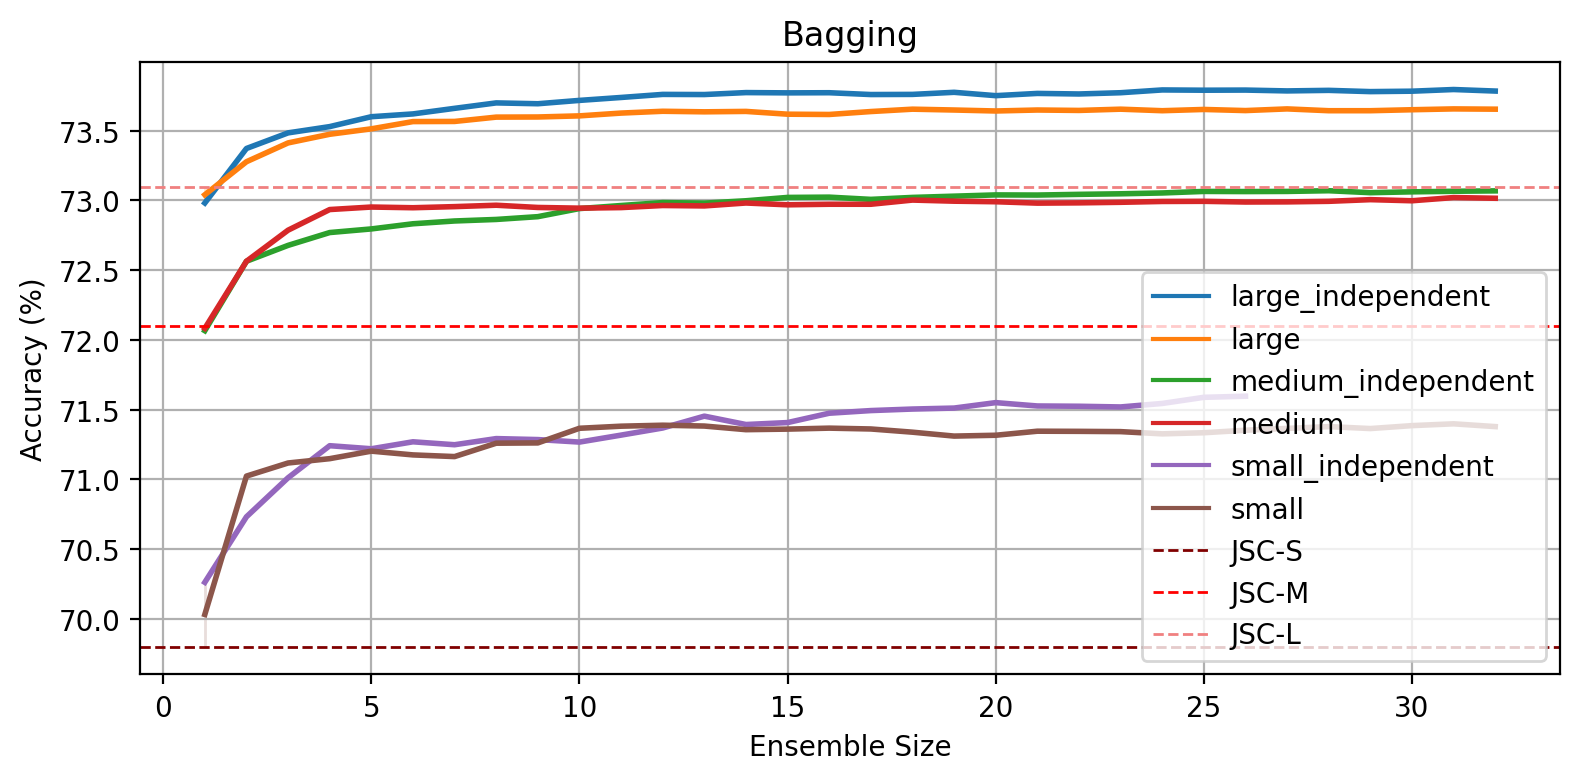

In [6]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
display(plot_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # label="JSC-S Ensemble"
)
plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
ax.grid()
ax.legend()
ax.set_title("Bagging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
fig.tight_layout()
plt.savefig("bagging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("bagging_acc_v_ensemble_size_lineplot.png")

## AdaBoost

In [7]:
experiment_dir = "../adaboost"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
adaboost_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,best_single_model_large,73.100,0.000,1,large
1,adaboost_large_independent_ensemble_size32,72.996,1.101,1,large_independent
2,adaboost_large_independent_ensemble_size32,72.996,1.134,2,large_independent
3,adaboost_large_independent_ensemble_size32,72.996,1.162,3,large_independent
4,adaboost_large_ensemble_size32,72.996,1.131,2,large
...,...,...,...,...,...
135,adaboost_small_ensemble_size32,69.717,1.327,14,small
136,adaboost_small_ensemble_size32,69.701,1.271,8,small
137,adaboost_small_ensemble_size32,69.681,1.287,9,small
138,adaboost_small_ensemble_size32,69.650,1.297,10,small


,trial,accuracy,loss,ensemble_size,model_size
0,best_single_model_large,73.100,0.000,1,large
1,adaboost_large_independent_ensemble_size32,72.996,1.101,1,large_independent
2,adaboost_large_independent_ensemble_size32,72.996,1.134,2,large_independent
3,adaboost_large_independent_ensemble_size32,72.996,1.162,3,large_independent
4,adaboost_large_ensemble_size32,72.996,1.131,2,large
...,...,...,...,...,...
135,adaboost_small_ensemble_size32,69.717,1.327,14,small
136,adaboost_small_ensemble_size32,69.701,1.271,8,small
137,adaboost_small_ensemble_size32,69.681,1.287,9,small
138,adaboost_small_ensemble_size32,69.650,1.297,10,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


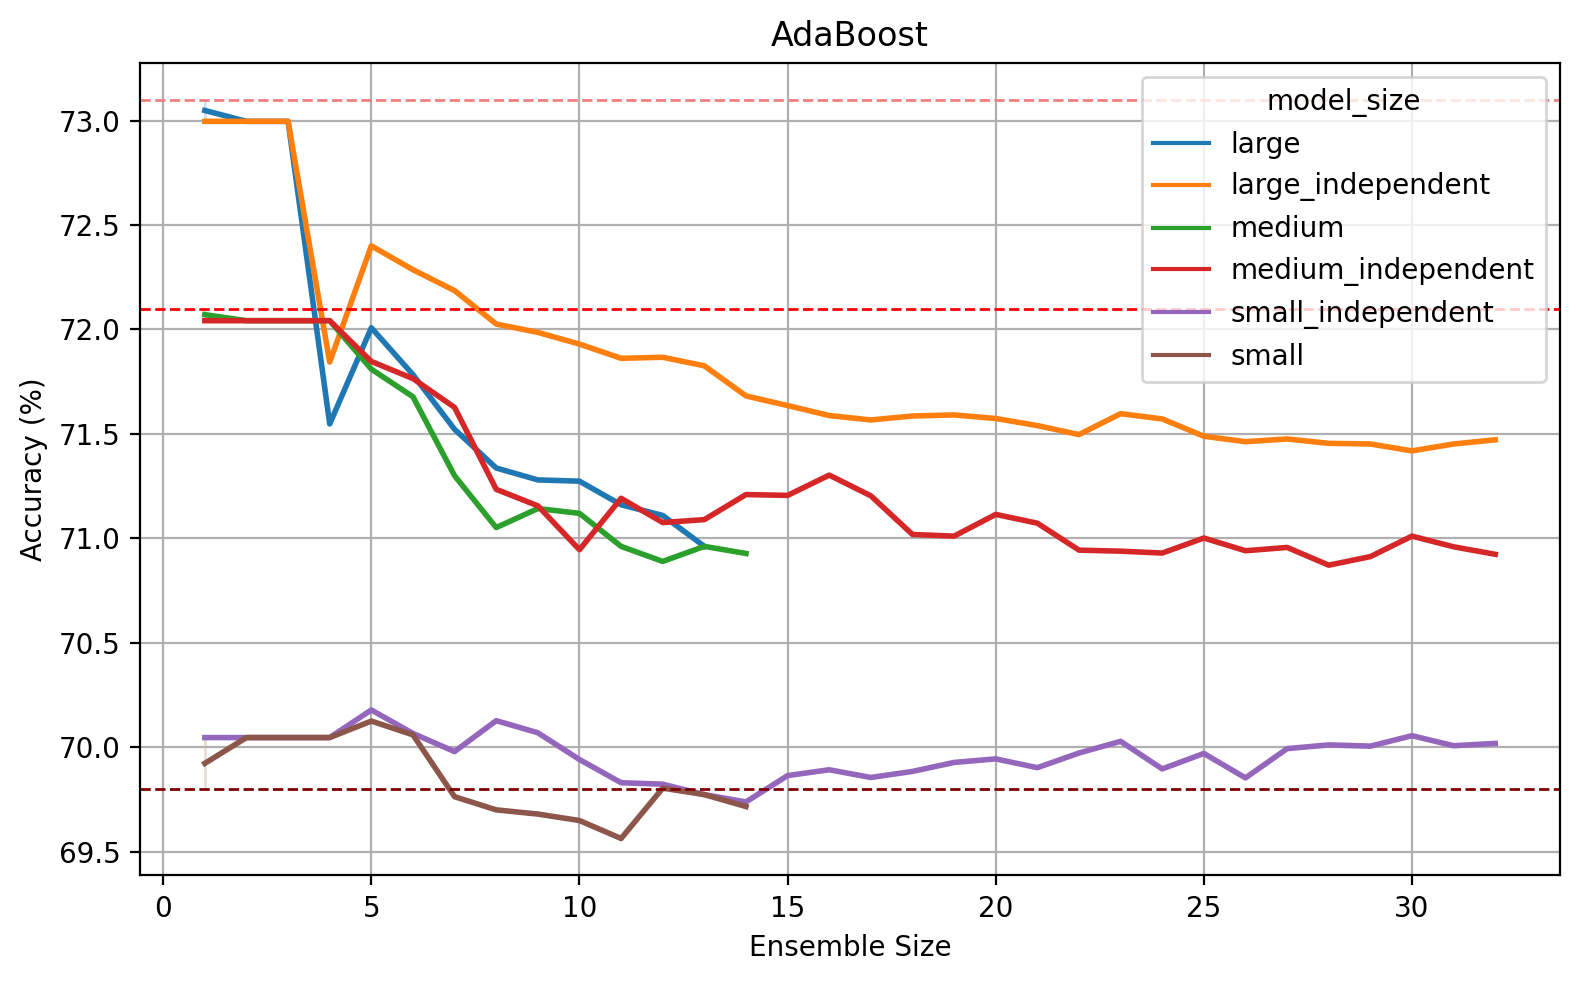

In [8]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
display(plot_df)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
)
plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
ax.grid()
# ax.legend()
ax.set_title("AdaBoost")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
fig.tight_layout()
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.png")

## Ensembling Comparison

In [9]:
# avg_df = averaging_df.loc[averaging_df["model_size"].isin(["small", "medium", "large"])]
# TODO: Pull out qavg results from averaging df
averaging_df["ensemble_method"] = averaging_df["model_size"].apply(lambda x: "Averaging")
bagging_df["ensemble_method"] = bagging_df["model_size"].apply(lambda x: "Bagging")
adaboost_df["ensemble_method"] = adaboost_df["model_size"].apply(lambda x: "AdaBoost")
all_df = pd.concat([averaging_df, bagging_df, adaboost_df])
all_df = add_single_model_data(all_df)
all_df

,trial,accuracy,loss,ensemble_size,model_size,ensemble_method
0,large_no_post_trans_ensemble_size32,75.210,0.687,32,large_no_post,Averaging
1,uniform_input_large_ensemble_size32,75.190,0.690,32,uniform_input_large,Averaging
2,large_no_post_trans_ensemble_size16,75.170,0.688,16,large_no_post,Averaging
3,medium_no_post_trans_ensemble_size32,75.130,0.691,32,medium_no_post,Averaging
4,averaging_large_ensemble_size32,75.120,0.688,32,large,Averaging
...,...,...,...,...,...,...
473,adaboost_small_ensemble_size32,69.650,1.297,10,small,AdaBoost
474,adaboost_small_ensemble_size32,69.564,1.307,11,small,AdaBoost
475,best_single_model_small,69.800,0.000,1,small,NaN
476,best_single_model_medium,72.100,0.000,1,medium,NaN


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


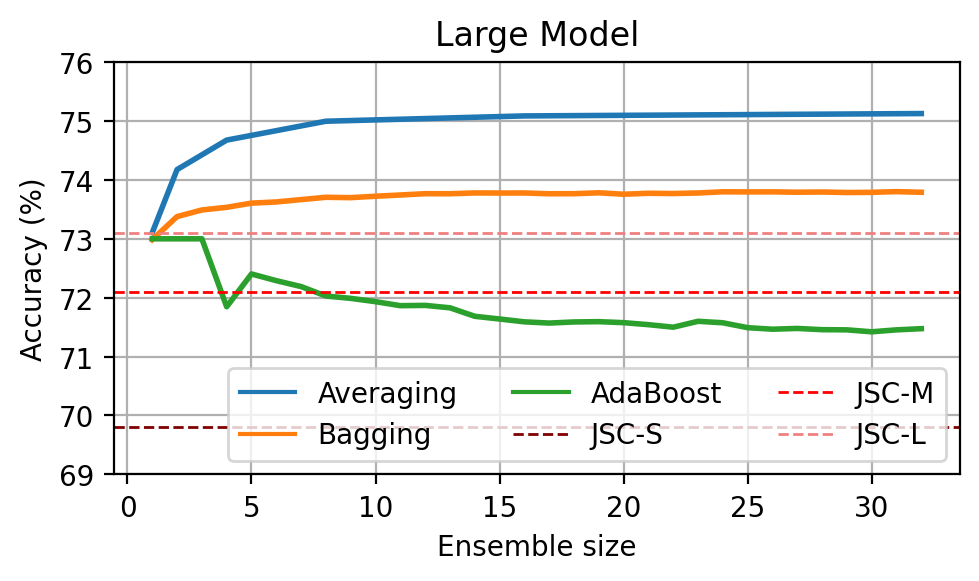

In [10]:
# Line plot for large model
fig, ax = plt.subplots(figsize=(5, 3))

large_df = averaging_df[averaging_df["model_size"] == "large"]
large_df = pd.concat([large_df, bagging_df[bagging_df["model_size"] == "large_independent"]])
large_df = pd.concat([large_df, adaboost_df[adaboost_df["model_size"] == "large_independent"]])
ax = sns.lineplot(
    data=large_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend(loc="lower right", ncol=3)
ax.set_ylim([69, 76])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Large Model")

fig.tight_layout()

/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


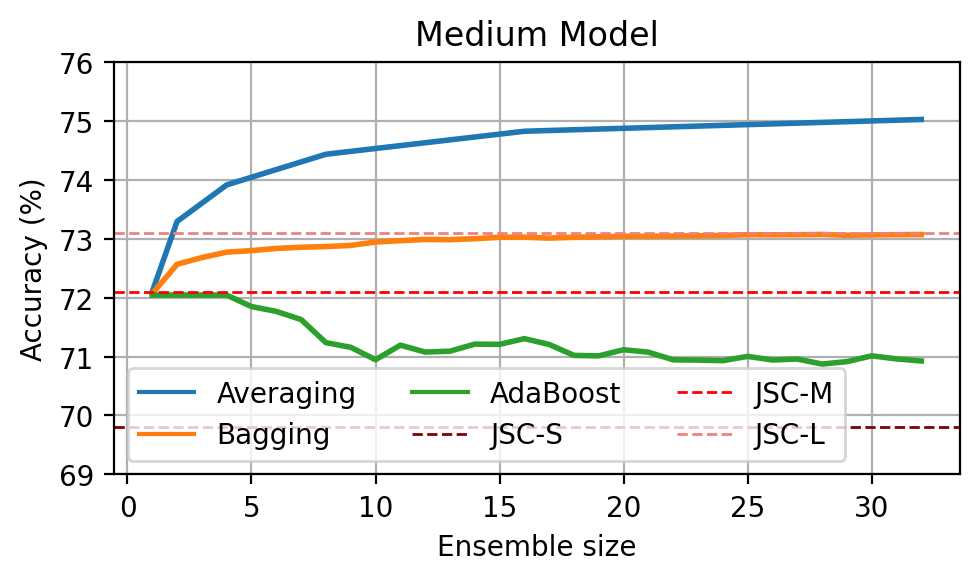

In [11]:
# Line plot for medium model
fig, ax = plt.subplots(figsize=(5, 3))

med_df = averaging_df[averaging_df["model_size"] == "medium"]
med_df = pd.concat([med_df, bagging_df[bagging_df["model_size"] == "medium_independent"]])
med_df = pd.concat([med_df, adaboost_df[adaboost_df["model_size"] == "medium_independent"]])
ax = sns.lineplot(
    data=med_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend(ncol=3)
ax.set_ylim([69, 76])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Medium Model")

fig.tight_layout()

/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


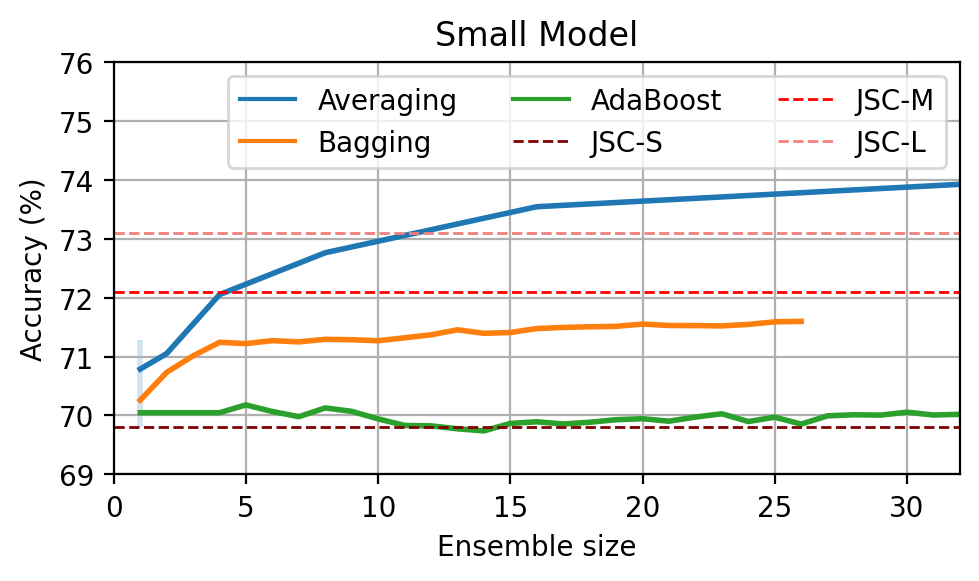

In [12]:
# Line plot for small model
fig, ax = plt.subplots(figsize=(5, 3))

small_df = averaging_df[averaging_df["model_size"] == "small"]
small_df = pd.concat([small_df, bagging_df[bagging_df["model_size"] == "small_independent"]])
small_df = pd.concat([small_df, adaboost_df[adaboost_df["model_size"] == "small_independent"]])
ax = sns.lineplot(
    data=small_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend(ncol=3)
ax.set_ylim([69, 76])
ax.set_xlim([0, 32])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Small Model")

fig.tight_layout()

/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


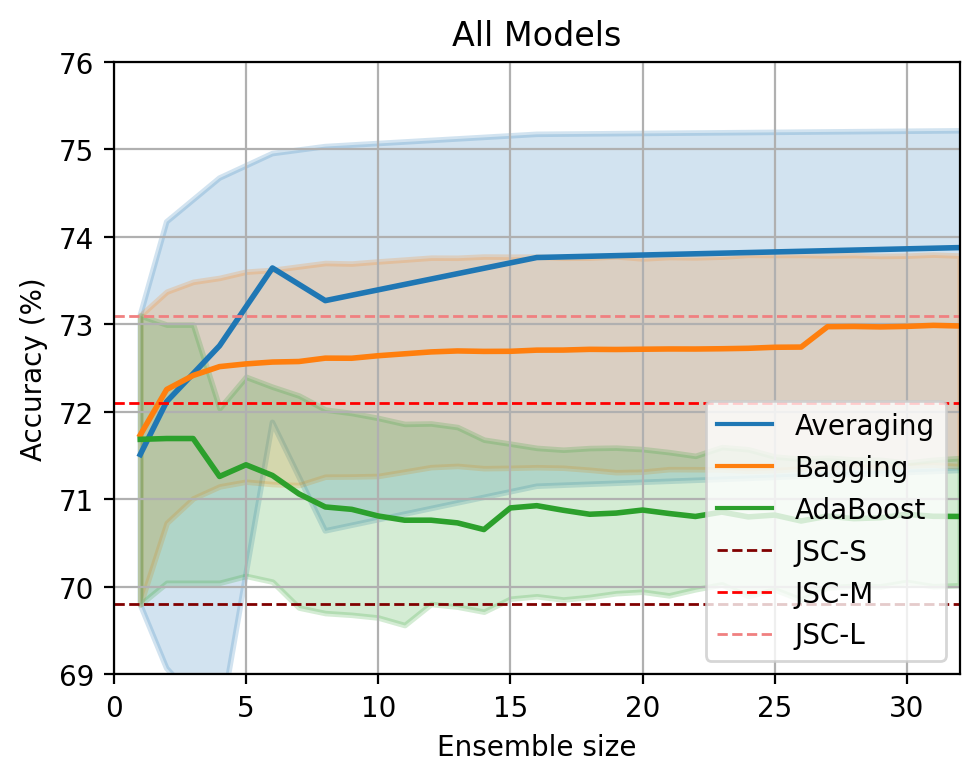

In [13]:
# Line plot for all
fig, ax = plt.subplots(figsize=(5, 4))

ax = sns.lineplot(
    data=all_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend(loc="lower right")
ax.set_ylim([69, 76])
ax.set_xlim([0, 32])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("All Models")

fig.tight_layout()